In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import csv
import requests
from bs4 import BeautifulSoup
import requests

In [2]:
# Link to Data Used = https://github.com/nytimes/covid-19-data

In [3]:
# Let's try to take out the download step by using requests

url = 'https://github.com/nytimes/covid-19-data/blob/master/us-states.csv'
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

table = soup.find("table", {"class":"js-csv-data"})

total_us_data = pd.read_html(str(table))[0]

total_us_data.drop(columns='Unnamed: 0', inplace=True)

total_us_data.to_csv('most_recent_data.csv')

In [4]:
# Always have at least one of these marked out
# total_us_data = pd.read_csv('NYT-US-Data/us-states-2020-04-27.csv').drop(columns='Unnamed: 0')

In [5]:
# let's give the data a look
total_us_data.head()

date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0
2  2020-01-23  Washington    53      1       0
3  2020-01-24    Illinois    17      1       0
4  2020-01-24  Washington    53      1       0

In [6]:
# Let's check for nulls
total_us_data.isnull().sum()

date      0
state     0
fips      0
cases     0
deaths    0
dtype: int64

In [7]:
# Let's check on the different states
total_us_data.state.unique()

array(['Washington', 'Illinois', 'California', 'Arizona', 'Massachusetts',
       'Wisconsin', 'Texas', 'Nebraska', 'Utah', 'Oregon', 'Florida',
       'New York', 'Rhode Island', 'Georgia', 'New Hampshire',
       'North Carolina', 'New Jersey', 'Colorado', 'Maryland', 'Nevada',
       'Tennessee', 'Hawaii', 'Indiana', 'Kentucky', 'Minnesota',
       'Oklahoma', 'Pennsylvania', 'South Carolina',
       'District of Columbia', 'Kansas', 'Missouri', 'Vermont',
       'Virginia', 'Connecticut', 'Iowa', 'Louisiana', 'Ohio', 'Michigan',
       'South Dakota', 'Arkansas', 'Delaware', 'Mississippi',
       'New Mexico', 'North Dakota', 'Wyoming', 'Alaska', 'Maine',
       'Alabama', 'Idaho', 'Montana', 'Puerto Rico', 'Virgin Islands',
       'Guam', 'West Virginia', 'Northern Mariana Islands'], dtype=object)

### Let's Check on and Add Some Data

In [8]:
# Date isn't DateTime Yet
total_us_data.dtypes

date      object
state     object
fips       int64
cases      int64
deaths     int64
dtype: object

In [9]:
# Fixed it
total_us_data['date'] = pd.to_datetime(total_us_data['date'])

In [10]:
# Took me a few days, but I figured out how to do pct_change with groupby
# This will show the percent change in cases by day
total_us_data['percent_change'] = total_us_data.groupby('state').cases.pct_change()
total_us_data['percent_change'].fillna(0, inplace=True)

In [11]:
# Let's add a difference column
total_us_data['change_in_cases'] = total_us_data.groupby('state')['cases'].diff()

In [12]:
# Looks good
total_us_data.head()

date       state  fips  cases  deaths  percent_change  change_in_cases
0 2020-01-21  Washington    53      1       0             0.0              NaN
1 2020-01-22  Washington    53      1       0             0.0              0.0
2 2020-01-23  Washington    53      1       0             0.0              0.0
3 2020-01-24    Illinois    17      1       0             0.0              NaN
4 2020-01-24  Washington    53      1       0             0.0              0.0

In [13]:
# Let's try to add a few moving averages
# Change in Cases shortened to CIC
# Simple Moving Average shortened to SMA
total_us_data['cic_5_day_sma'] = total_us_data.groupby('state')['change_in_cases'].transform(lambda x: x.rolling(5, 1).mean())
total_us_data['cic_10_day_sma'] = total_us_data.groupby('state')['change_in_cases'].transform(lambda x: x.rolling(10, 1).mean())
total_us_data['cic_20_day_sma'] = total_us_data.groupby('state')['change_in_cases'].transform(lambda x: x.rolling(20, 1).mean())

In [14]:
total_us_data

date          state  fips   cases  deaths  percent_change  \
0     2020-01-21     Washington    53       1       0        0.000000   
1     2020-01-22     Washington    53       1       0        0.000000   
2     2020-01-23     Washington    53       1       0        0.000000   
3     2020-01-24       Illinois    17       1       0        0.000000   
4     2020-01-24     Washington    53       1       0        0.000000   
...          ...            ...   ...     ...     ...             ...   
12439 2020-10-14       Virginia    51  161610    3381        0.005006   
12440 2020-10-14     Washington    53  100068    2319        0.007623   
12441 2020-10-14  West Virginia    54   18818     391        0.014174   
12442 2020-10-14      Wisconsin    55  167441    1549        0.020130   
12443 2020-10-14        Wyoming    56    8177      57        0.026745   

       change_in_cases  cic_5_day_sma  cic_10_day_sma  cic_20_day_sma  
0                  NaN            NaN             NaN             NaN  
1                  0.0            0.0             0.0            0.00  
2                  0.0            0.0             0.0            0.00  
3                  NaN            NaN             NaN             NaN  
4                  0.0            0.0             0.0            0.00  
...                ...            ...             ...             ...  
12439            805.0          992.2           974.0          905.90  
12440            757.0          646.2           654.1          573.55  
12441            263.0          222.2           219.0          205.60  
12442           3304.0         2922.0          2750.0         2634.90  
12443            213.0          168.4           167.3          143.60  

[12444 rows x 10 columns]

In [15]:
# Let's read this in to make the graphs easier
state_action = pd.read_csv('state_action.csv')
state_action = state_action.set_index('state')

In [16]:
# And let's convert these back to datetime
state_action.state_of_emergency = pd.to_datetime(state_action.state_of_emergency)
state_action.stay_at_home = pd.to_datetime(state_action.stay_at_home)

### Separating the Data by State

In [17]:
# Let's make a funciton to seperate these
def state_info(state):
    data = total_us_data[total_us_data.state == state]
    data.date = pd.to_datetime(data.date)
    data = data.set_index(data.date)
#     data['percent_change'] = data.cases.pct_change()
#     data.percent_change.fillna(0, inplace=True)
    return data.drop(labels='date', axis=1)

In [18]:
# Function Test
state_info('Northern Mariana Islands').head()

C:\Users\nolan\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


state  fips  cases  deaths  percent_change  \
date                                                                        
2020-03-28  Northern Mariana Islands    69      2       0             0.0   
2020-03-29  Northern Mariana Islands    69      2       0             0.0   
2020-03-30  Northern Mariana Islands    69      2       0             0.0   
2020-03-31  Northern Mariana Islands    69      2       0             0.0   
2020-04-01  Northern Mariana Islands    69      6       1             2.0   

            change_in_cases  cic_5_day_sma  cic_10_day_sma  cic_20_day_sma  
date                                                                        
2020-03-28              NaN            NaN             NaN             NaN  
2020-03-29              0.0            0.0             0.0             0.0  
2020-03-30              0.0            0.0             0.0             0.0  
2020-03-31              0.0            0.0             0.0             0.0  
2020-04-01              4.0            1.0             1.0             1.0

In [19]:
# Don't know how to make a function to do this, so here we go
washington_data = state_info('Washington')
illinois_data = state_info('Illinois')
california_data = state_info('California')
arizona_data = state_info('Arizona')
massachusetts_data = state_info('Massachusetts')
wisconsin_data = state_info('Wisconsin')
texas_data = state_info('Texas')
nebraska_data = state_info('Nebraska')
utah_data = state_info('Utah')
oregon_data = state_info('Oregon')
florida_data = state_info('Florida')
new_york_data = state_info('New York')
rhode_island_data = state_info('Rhode Island')
georgia_data = state_info('Georgia')
new_hampshire_data = state_info('New Hampshire')
north_carolina_data = state_info('North Carolina')
new_jersey_data = state_info('New Jersey')
colorado_data = state_info('Colorado')
maryland_data = state_info('Maryland')
nevada_data = state_info('Nevada')
tennessee_data = state_info('Tennessee')
hawaii_data = state_info('Hawaii')
indiana_data = state_info('Indiana')
kentucky_data = state_info('Kentucky')
minnesota_data = state_info('Minnesota')
oklahoma_data = state_info('Oklahoma')
pennsylvania_data = state_info('Pennsylvania')
south_carolina_data = state_info('South Carolina')
dc_data = state_info('District of Columbia')
kansas_data = state_info('Kansas')
missouri_data = state_info('Missouri')
vermont_data = state_info('Vermont')
virginia_data = state_info('Virginia')
connecticut_data = state_info('Connecticut')
iowa_data = state_info('Iowa')
louisiana_data = state_info('Louisiana')
ohio_data = state_info('Ohio')
michigan_data = state_info('Michigan')
south_dakota_data = state_info('South Dakota')
arkansas_data = state_info('Arkansas')
delaware_data = state_info('Delaware')
mississippi_data = state_info('Mississippi')
new_mexico_data = state_info('New Mexico')
north_dakota_data = state_info('North Dakota')
wyoming_data = state_info('Wyoming')
alaska_data = state_info('Alaska')
maine_data = state_info('Maine')
alabama_data = state_info('Alabama')
idaho_data = state_info('Idaho')
montana_data = state_info('Montana')
puerto_rico_data = state_info('Puerto Rico')
virgin_islands_data = state_info('Virgin Islands')
guam_data = state_info('Guam')
west_virginia_data = state_info('West Virginia')
north_mariana_islands_data = state_info('Northern Mariana Islands')
american_samoa_data = state_info('American Samoa')

In [20]:
# Changing the Pandas Settings Real Quick
pd.options.display.min_rows = 50

In [21]:
pd.options.display.min_rows

50

# Function That Makes The Graphs

In [22]:
# This will be the main graph funciton
def daily_change(state, title=None, state_of_emergency_declaration=None, 
                 stay_at_home_order=None, end_of_stay_at_home=None,
                 easter=None, fourth_of_july=None):
    
    plt.figure(figsize=(16, 9))
    
    if title == None:
        plt.title(label=f"{state.state[0]} Currently Has {state.cases[-1]} Cases In Total", size=24)
    else:
        plt.title(title, size=24)
    
    plt.plot(state.change_in_cases, label='Daily Change')
    plt.plot(state.cic_20_day_sma, label='20 Day Moving Average')
    
    state_of_emergency = state_action.state_of_emergency[state.state[0]]
    stay_at_home = state_action.stay_at_home[state.state[0]]
    week = dt.timedelta(days=7)
    
    # This adds the State of Emergency Declaration Date
    if state_of_emergency_declaration != None:
        if not pd.isna(state_of_emergency):
            plt.vlines(x=state_of_emergency, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='purple', label='State of Emergency Declaration')
            plt.vlines(x=state_of_emergency+week, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='purple', label='One Week After State of Emergency')
    
    # This add's the Stay at Home Order Date
    # The if not is to weed out states with no Stay at Home Orders
    if stay_at_home_order != None:
        if not pd.isna(stay_at_home):
            plt.vlines(x=state_action.stay_at_home[state.state[0]], ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='green', label='Stay At Home Order Enacted')
            plt.vlines(x=state_action.stay_at_home[state.state[0]]+week, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='green', label='One Week After Stay At Home')
    
    # Since Georgia and Texas are lifting their Stay at Home Orders, I have ot stay adding this
    if end_of_stay_at_home != None:
        plt.vlines(x=end_of_stay_at_home, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='red', label='End of Stay At Home Order')
        plt.vlines(x=end_of_stay_at_home+week, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='red', label='One Week After End of Stay At Home')
    
    
    # This adds Easter's markers, so it will noramally not be used
    if easter != None:
        plt.vlines(x=dt.date(2020, 4, 12), ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='gold', label='Easter Sunday')
        plt.vlines(x=dt.date(2020, 4, 19), ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='gold', label='One Week After Easter')
    
    
    # This adds the 4th of July's markers
    if fourth_of_july != None:
        plt.vlines(x=dt.date(2020, 7, 4), ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='navy', label='4th of July')
        plt.vlines(x=dt.date(2020, 7, 11), ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='navy', label='One Week After the 4th')
    
    
    # This will add text at the end of the line indicating the current number of cases
    plt.text(x=state.index[-1], y=(state.change_in_cases[-1]), s=f"{int(state.change_in_cases[-1])}\nNew\nCases", fontsize=10)
    # ^ Marking this out for now because no one line of code looks good for every state ^
    
    # Hopefully this auto goes to the best corner
    plt.legend()

# Let's Make Some Depressing Graphs

## Alabama (AL)

C:\Users\nolan\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


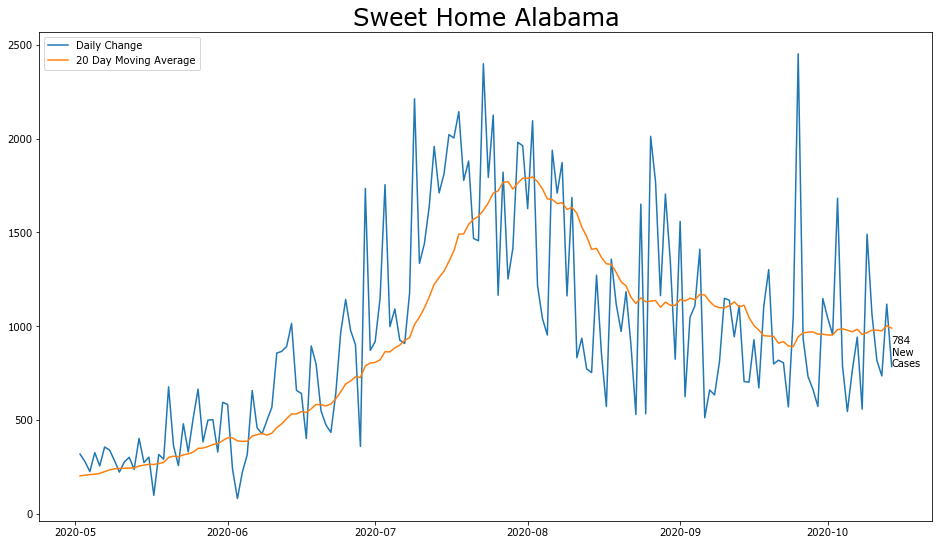

In [23]:
daily_change(alabama_data[50:], 'Sweet Home Alabama')

## Alaska (AK)

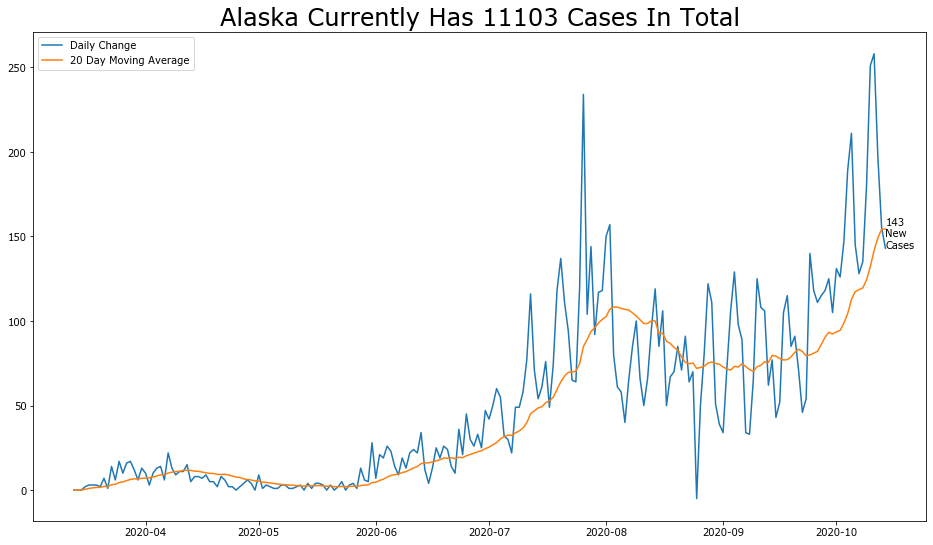

In [24]:
daily_change(alaska_data)

## American Samoa (AS)

In [25]:
# daily_change(american_samoa_data)

## Arizona (AZ)

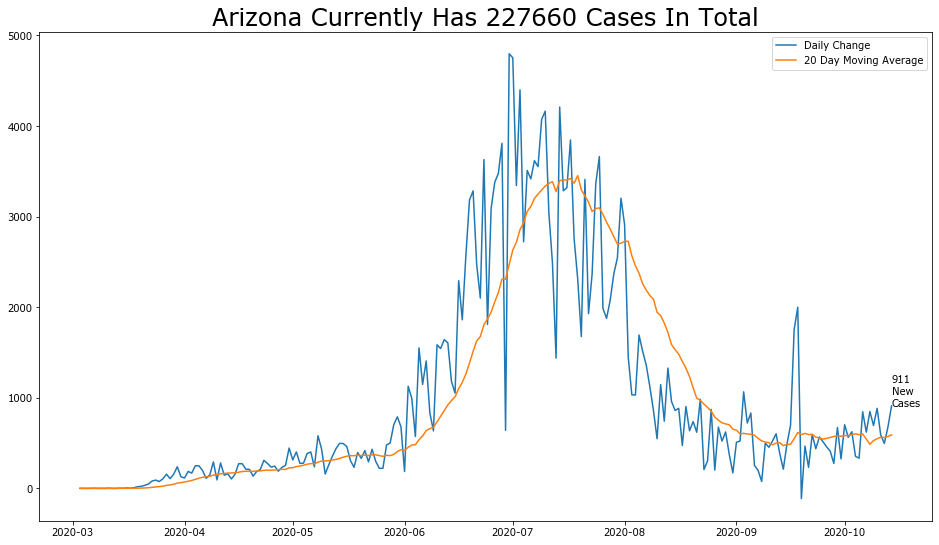

In [26]:
daily_change(arizona_data[37:])

## Arkansas (AR)

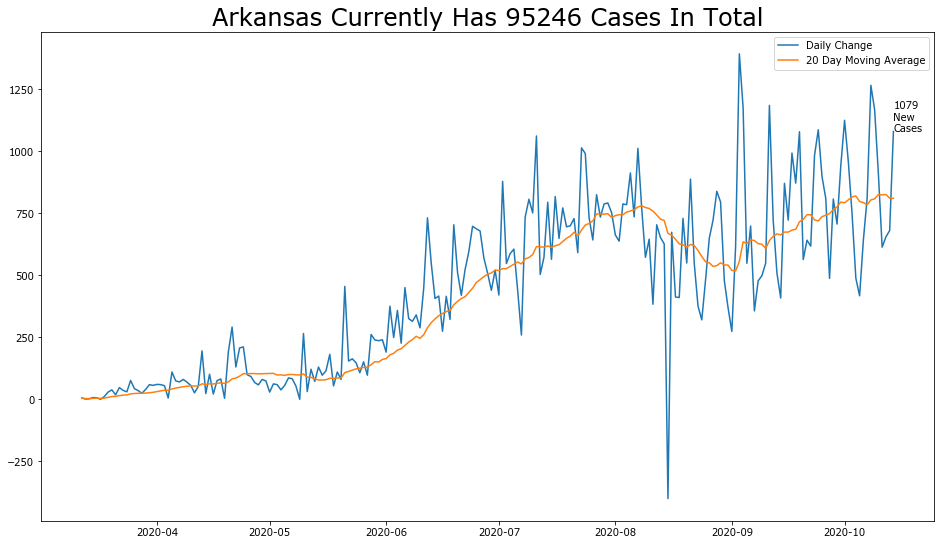

In [27]:
daily_change(arkansas_data)

## California (CA)

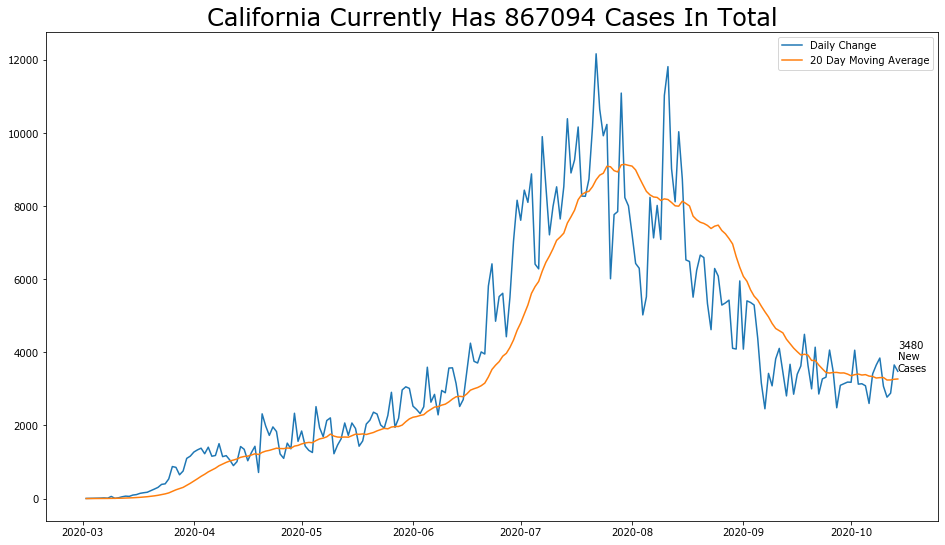

In [28]:
daily_change(california_data[37:])

## Colorado (CO)

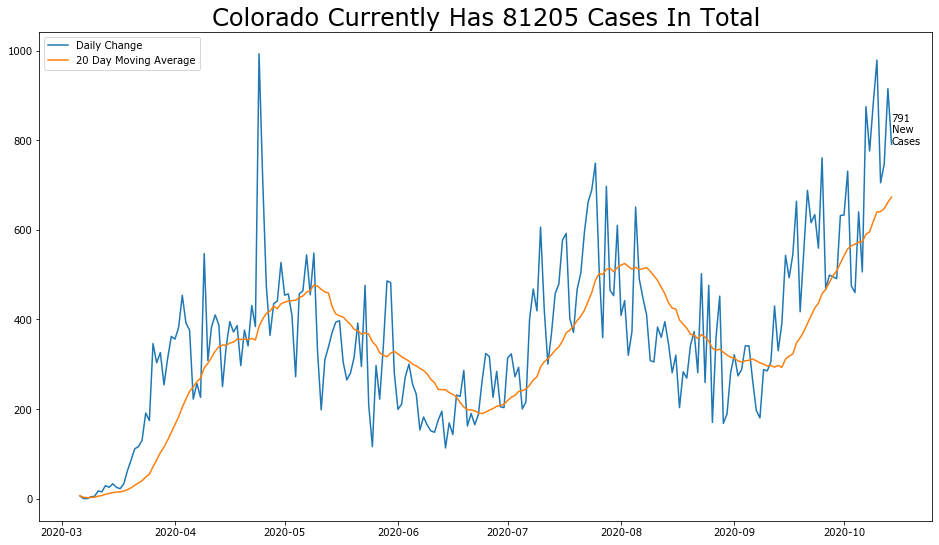

In [29]:
daily_change(colorado_data)

## Connecticut (CT)

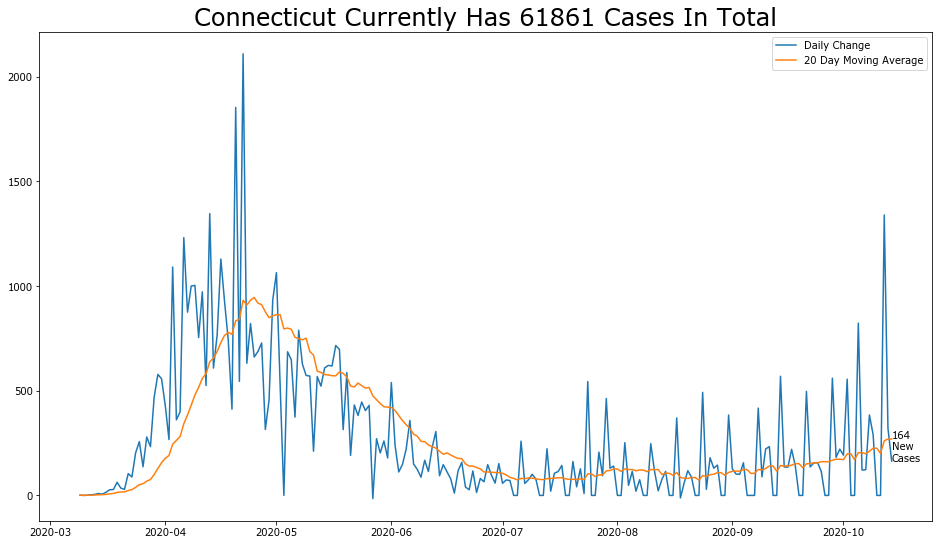

In [30]:
daily_change(connecticut_data)

## Delaware (DE)

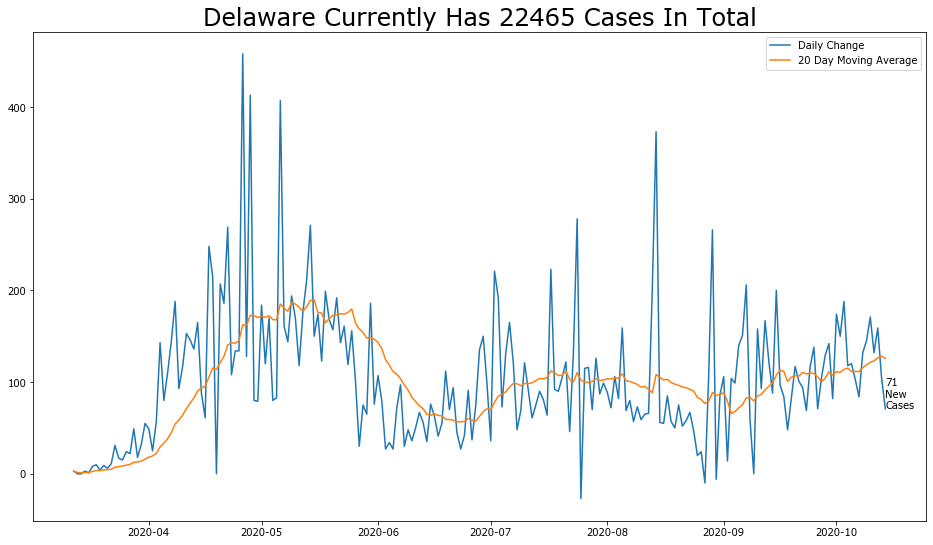

In [31]:
daily_change(delaware_data)

## District of Columbia (DC)

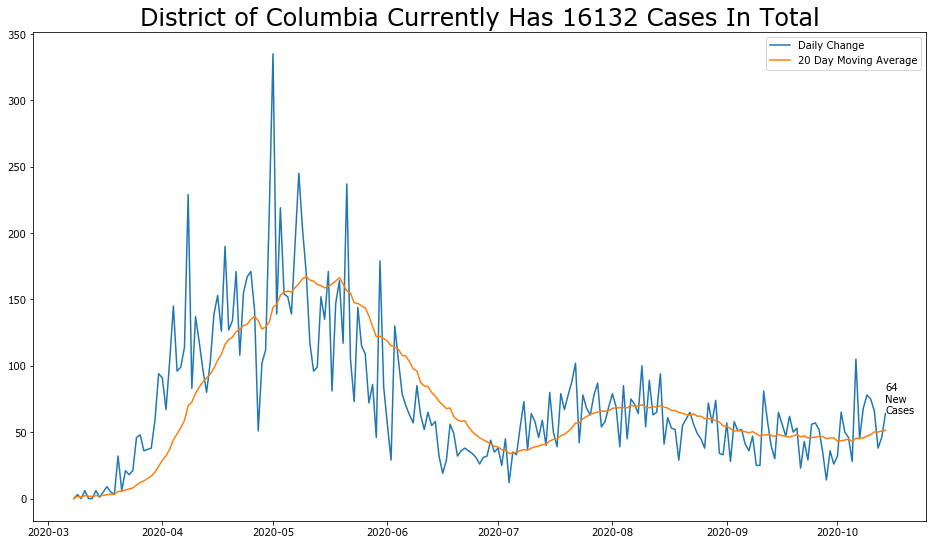

In [32]:
daily_change(dc_data)

## Florida (FL)

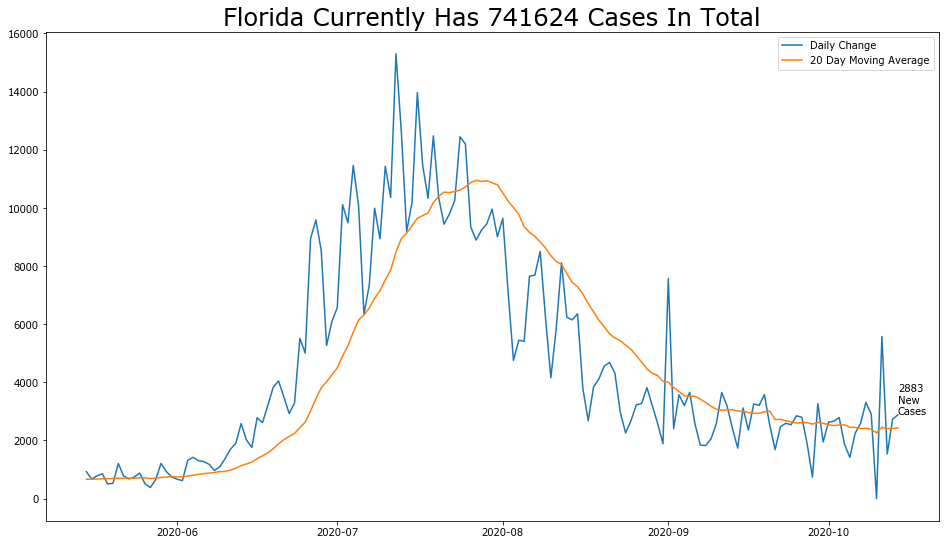

In [33]:
daily_change(florida_data[dt.date(2020, 5, 15):])

## Georgia (GA)

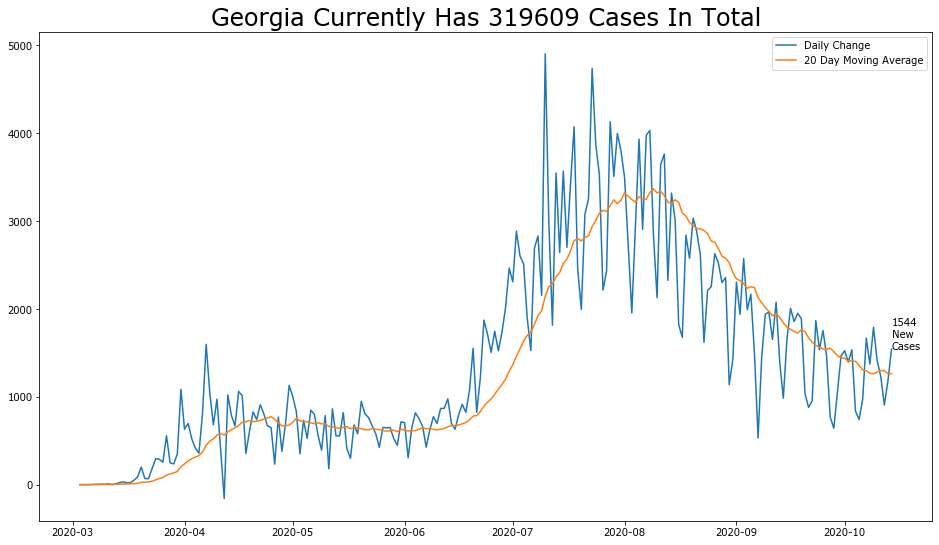

In [34]:
daily_change(georgia_data)

# https://thehill.com/homenews/state-watch/495527-georgia-to-lift-stay-at-home-order-for-most-residents-friday

## Guam (GU)

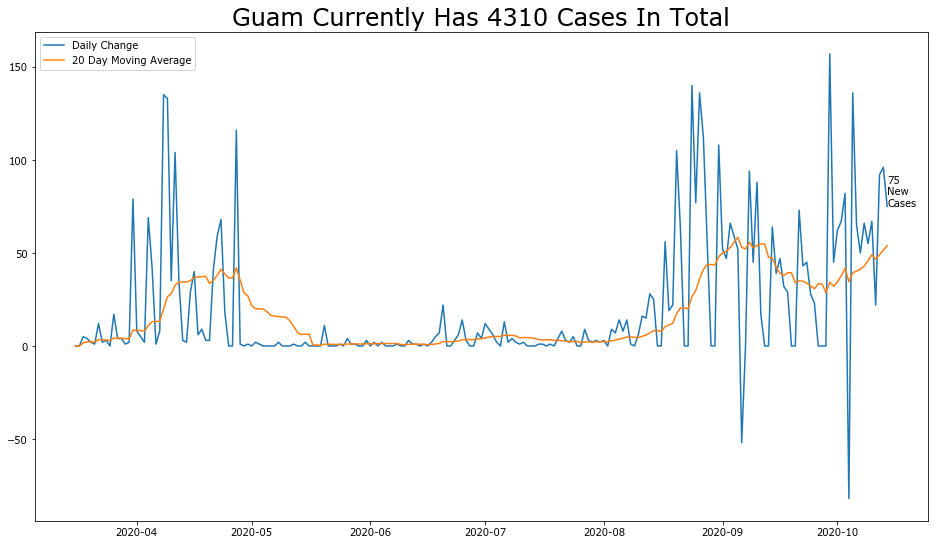

In [35]:
daily_change(guam_data)

## Hawaii (HI)

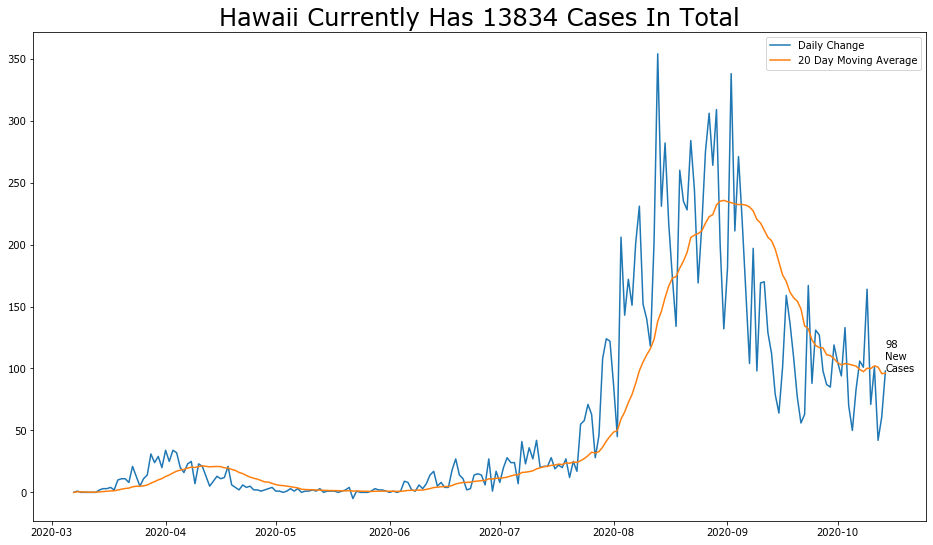

In [36]:
daily_change(hawaii_data)

## Idaho (ID)

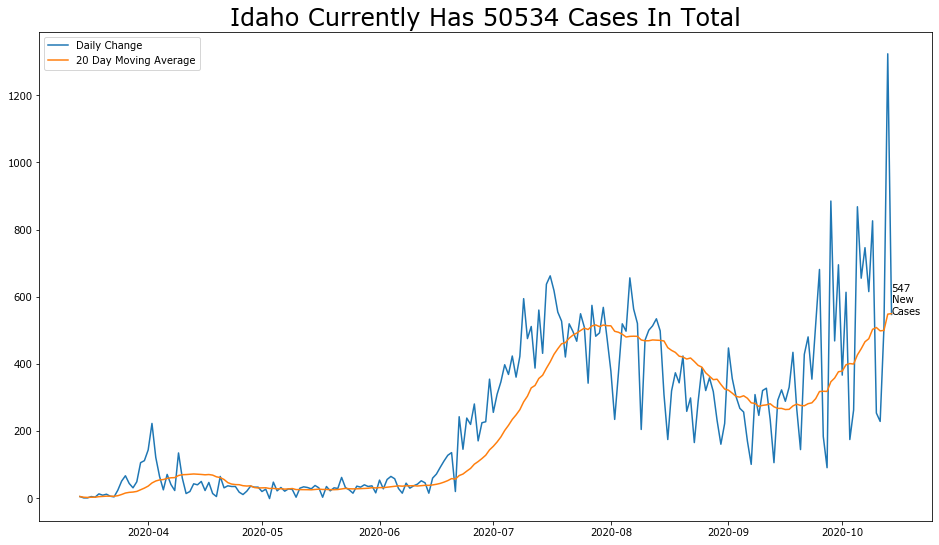

In [37]:
daily_change(idaho_data)

## Illinois (IL)

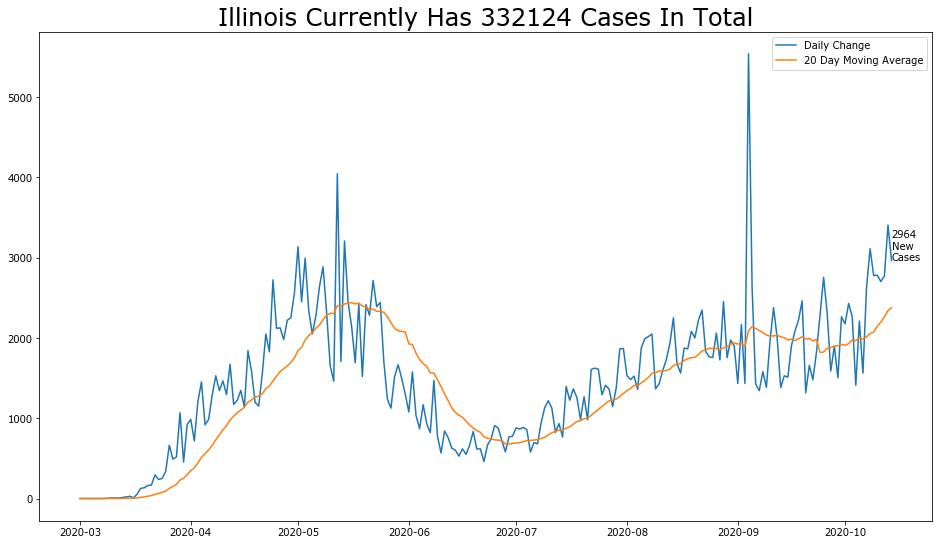

In [38]:
daily_change(illinois_data[37:])

## Indiana (IN)

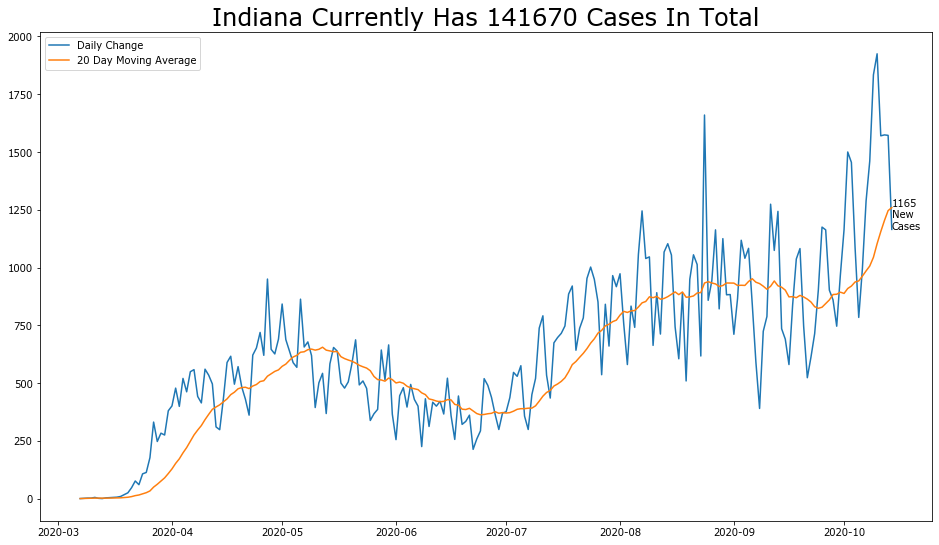

In [39]:
daily_change(indiana_data)

## Iowa (IA)

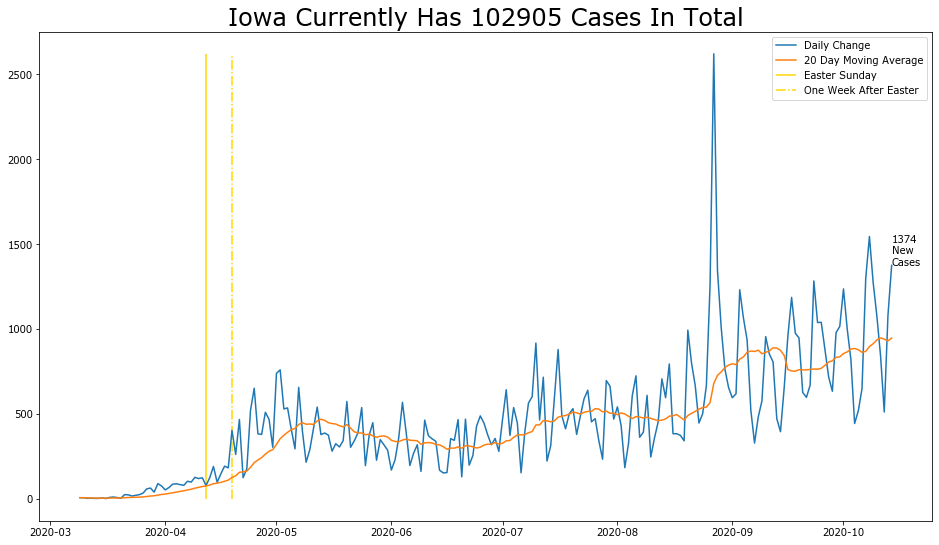

In [40]:
daily_change(iowa_data, easter="Bad")

## Kansas (KS)

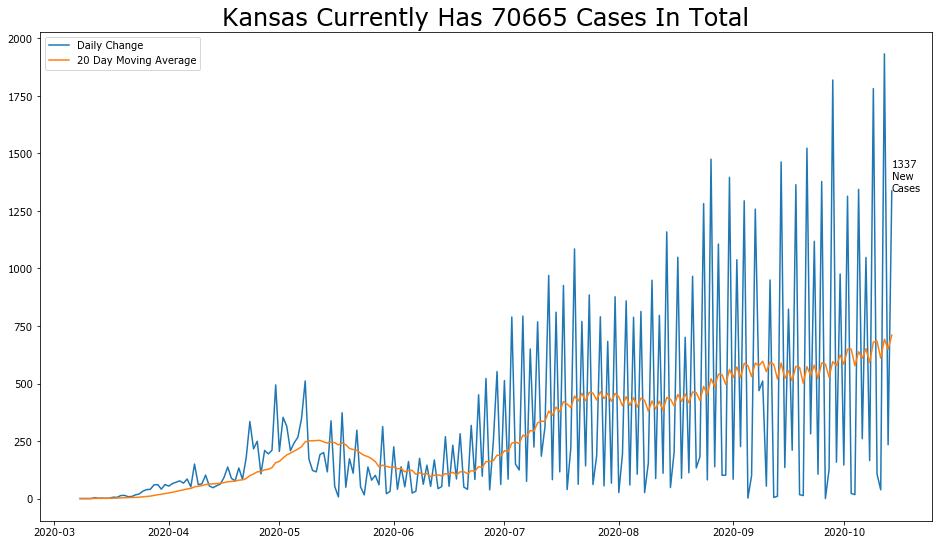

In [41]:
daily_change(kansas_data)

## Kentucky (KY)

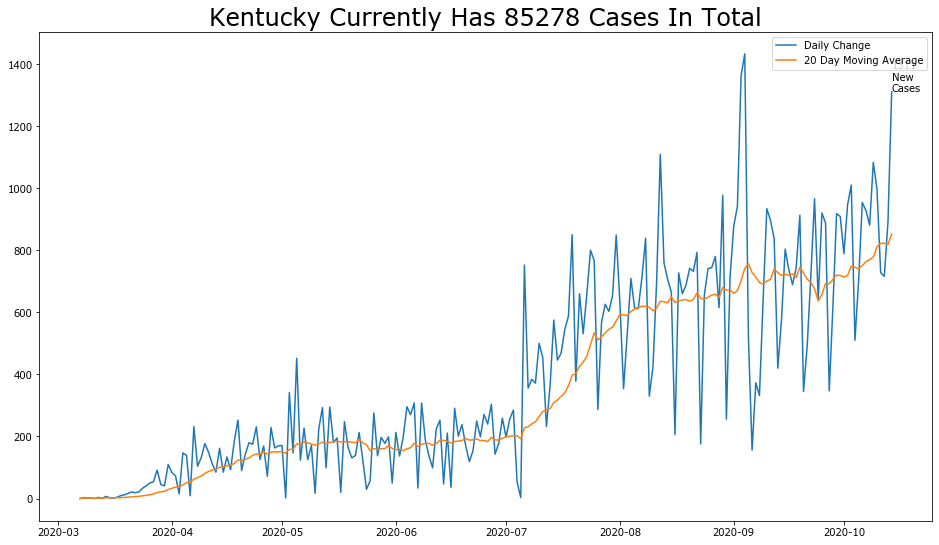

In [42]:
daily_change(kentucky_data)

## Louisiana (LA)

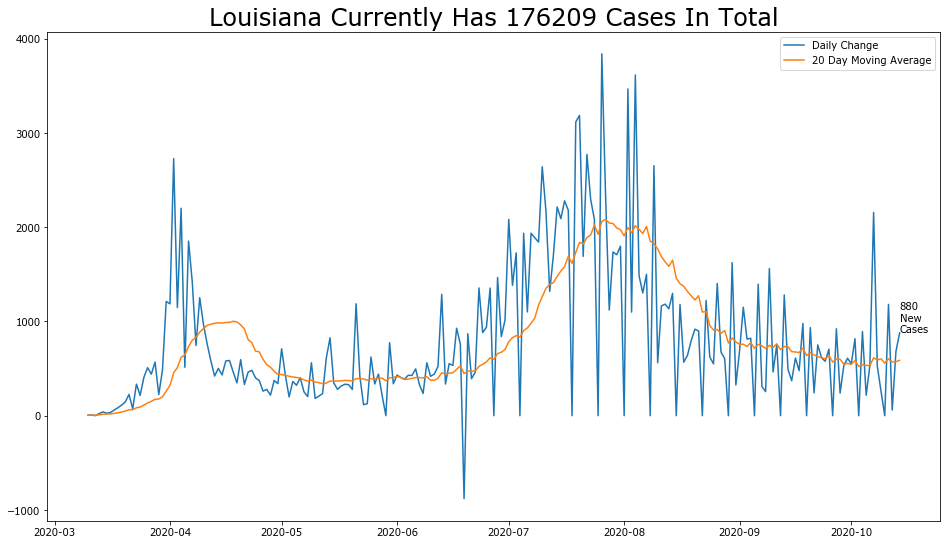

In [43]:
daily_change(louisiana_data)

## Maine (ME)

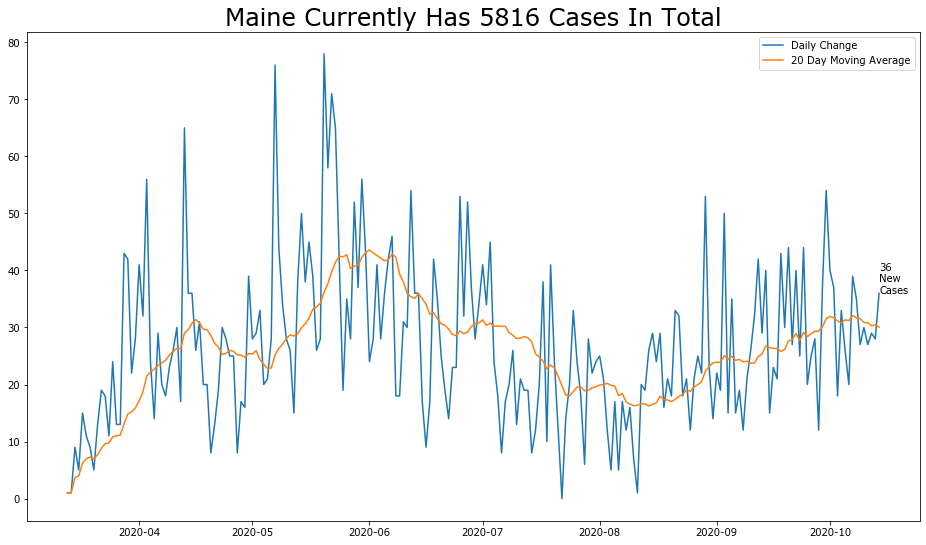

In [44]:
daily_change(maine_data)

## Maryland (MD)

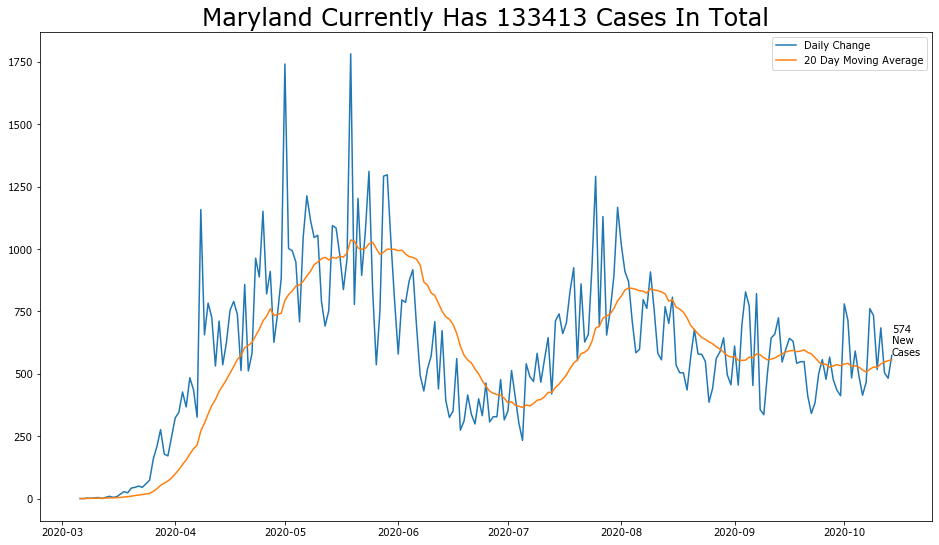

In [45]:
daily_change(maryland_data)

## Massachusetts (MA)

(-10, 5000)

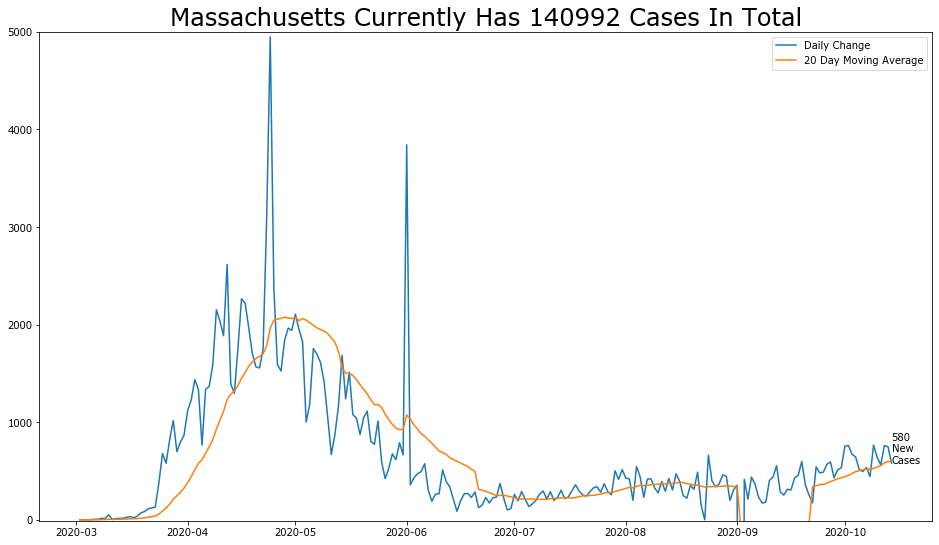

In [46]:
daily_change(massachusetts_data[30:])
plt.ylim(bottom=-10, top=5000)

# Patriots' Day is a local holiday in the state that would usually have a marathon happening during it
# plt.vlines(x=dt.date(2020, 4, 18), ymin=massachusetts_data.change_in_cases.min(), ymax=massachusetts_data.change_in_cases.max(), label="Begining of Patriots' Day Weekend", color='red')
# plt.vlines(x=dt.date(2020, 4, 25), ymin=massachusetts_data.change_in_cases.min(), ymax=massachusetts_data.change_in_cases.max(), label="One Week After Begining of Patriots' Day Weekend", color='red', linestyle='dashdot')

# plt.legend()

## Michigan (MI)

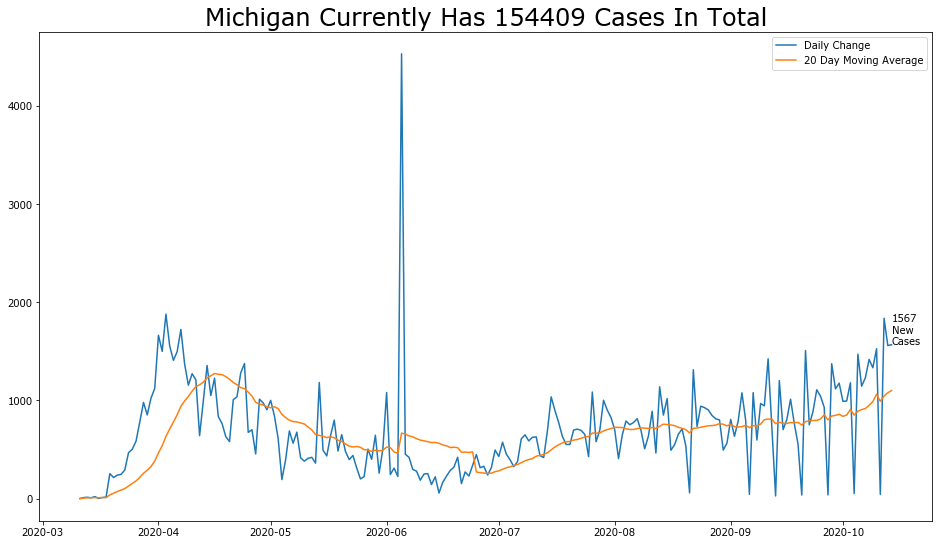

In [47]:
daily_change(michigan_data)

## Minnesota (MN)

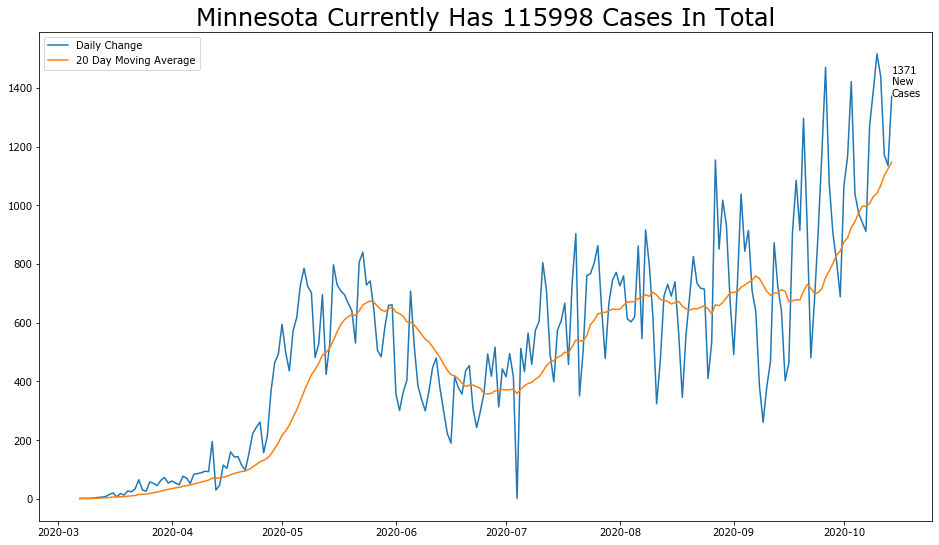

In [48]:
daily_change(minnesota_data)

## Mississippi (MS)

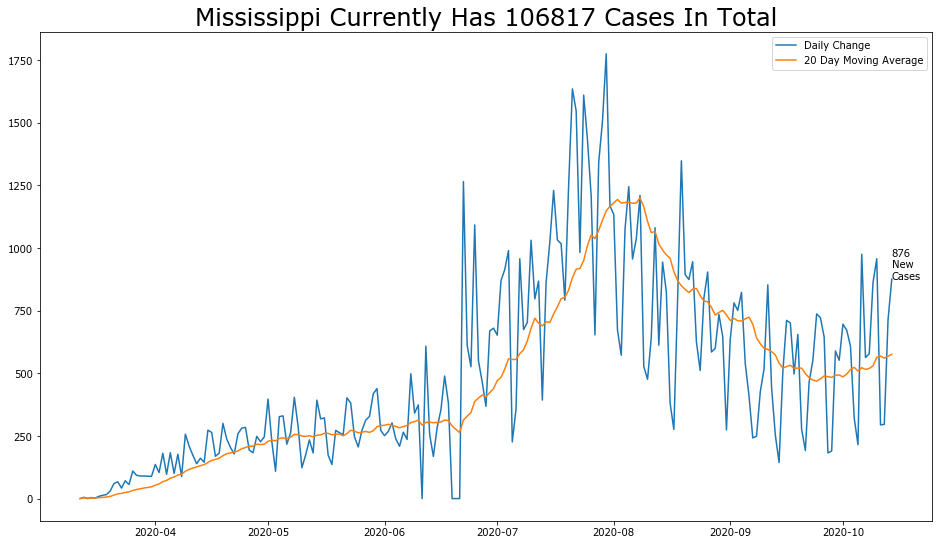

In [49]:
daily_change(mississippi_data)

## Missouri (MO)

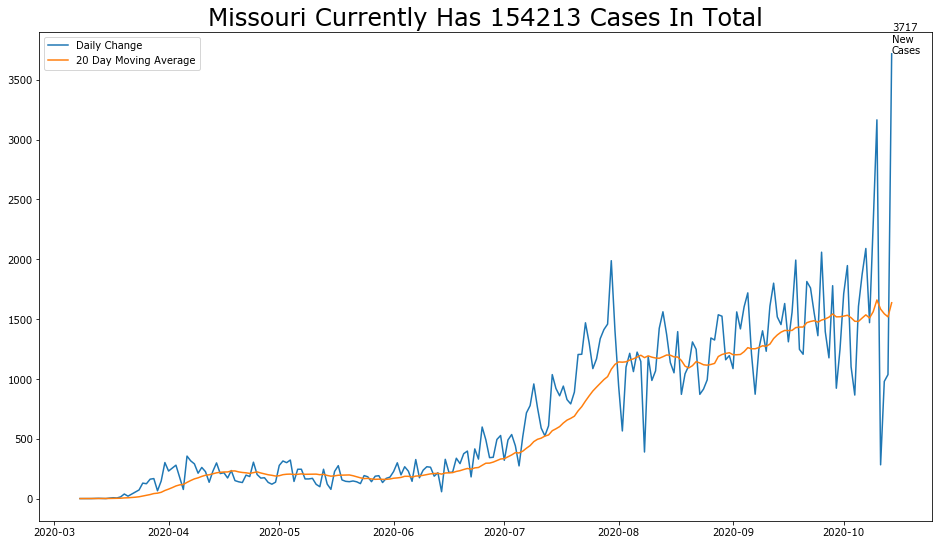

In [50]:
daily_change(missouri_data)

## Montana (MT)

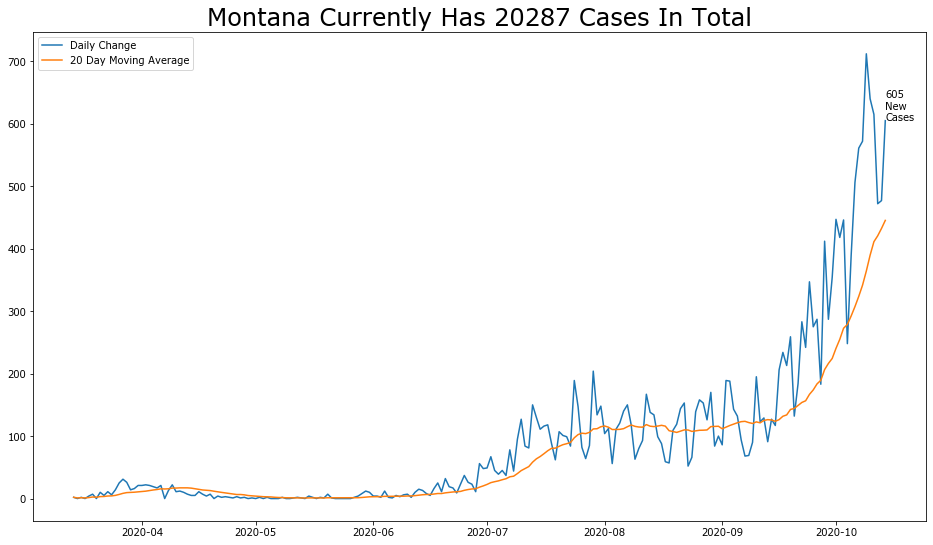

In [51]:
daily_change(montana_data)

## Nebraska (NE)

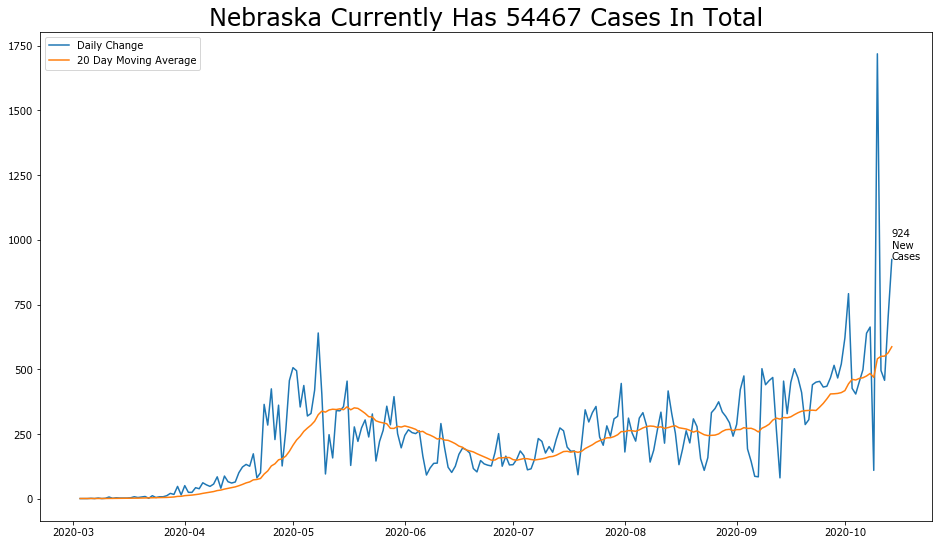

In [52]:
daily_change(nebraska_data[15:])

## Nevada (NV)

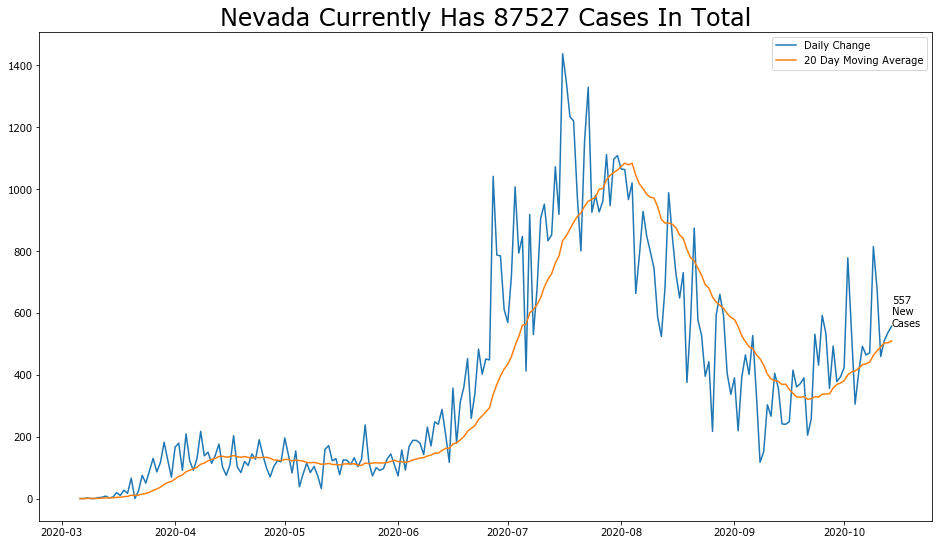

In [53]:
daily_change(nevada_data)

## New Hampshire (NH)

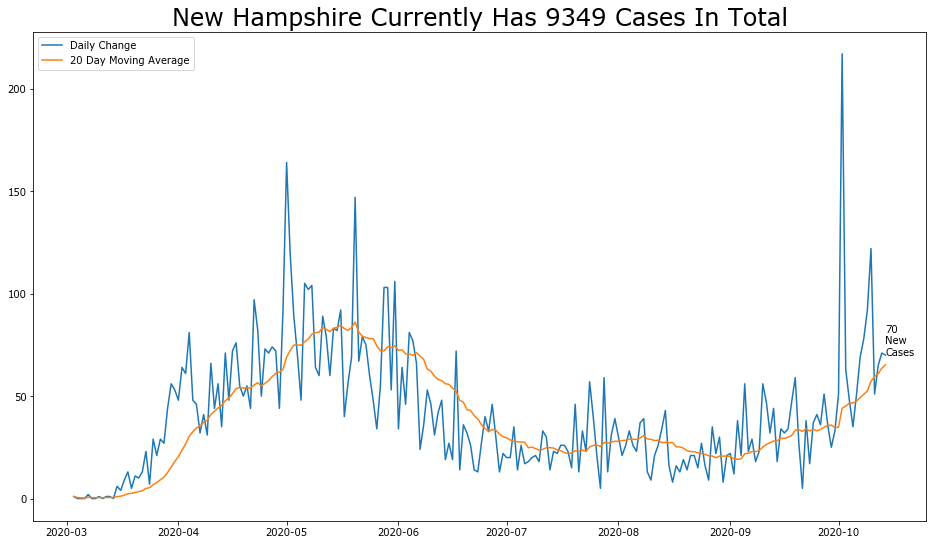

In [54]:
daily_change(new_hampshire_data)

## New Jersey (NJ)

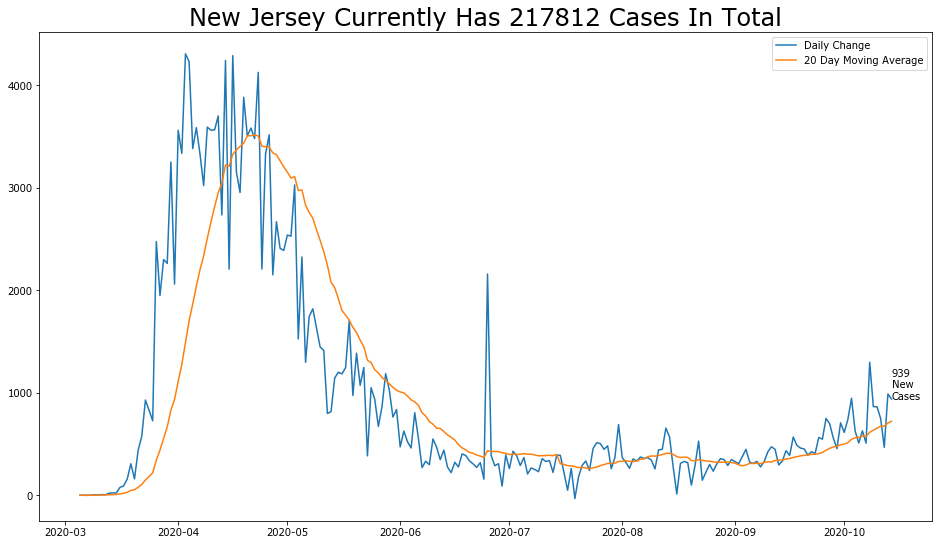

In [55]:
daily_change(new_jersey_data)

## New Mexico (NM)

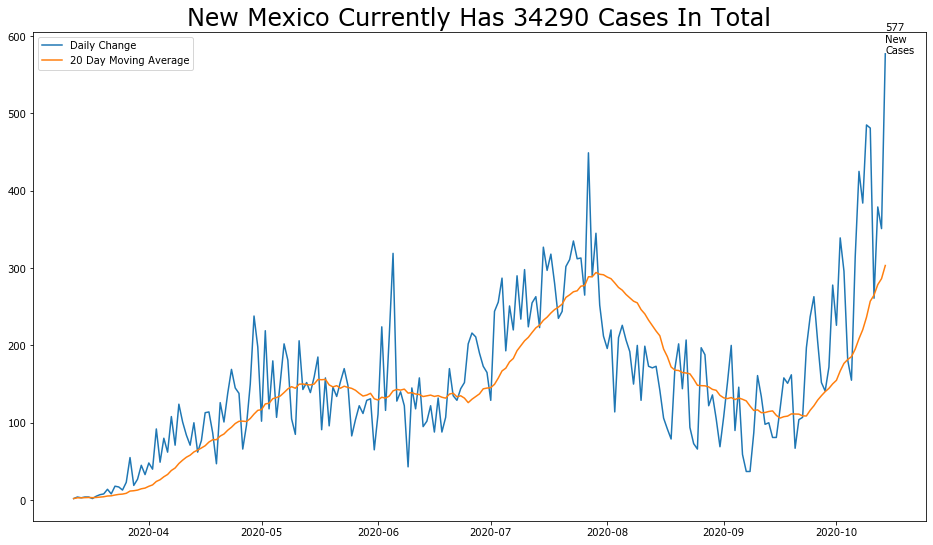

In [56]:
daily_change(new_mexico_data)

## New York (NY)

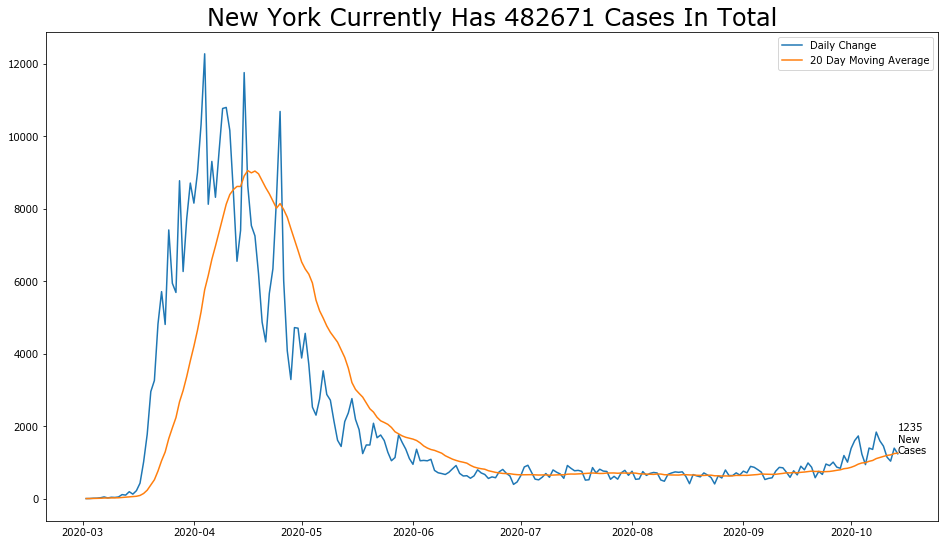

In [57]:
daily_change(new_york_data)

## North Carolina (NC)

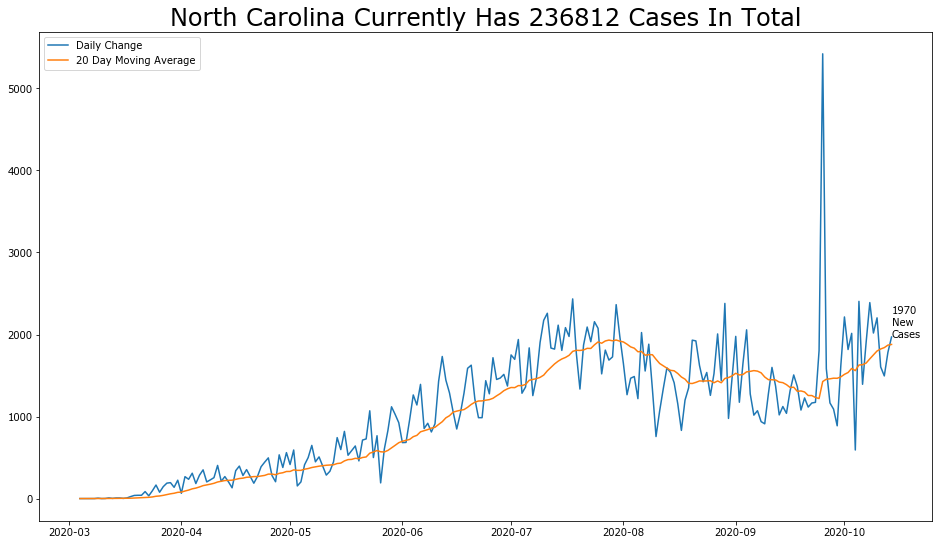

In [58]:
daily_change(north_carolina_data)

## North Dakota (ND)

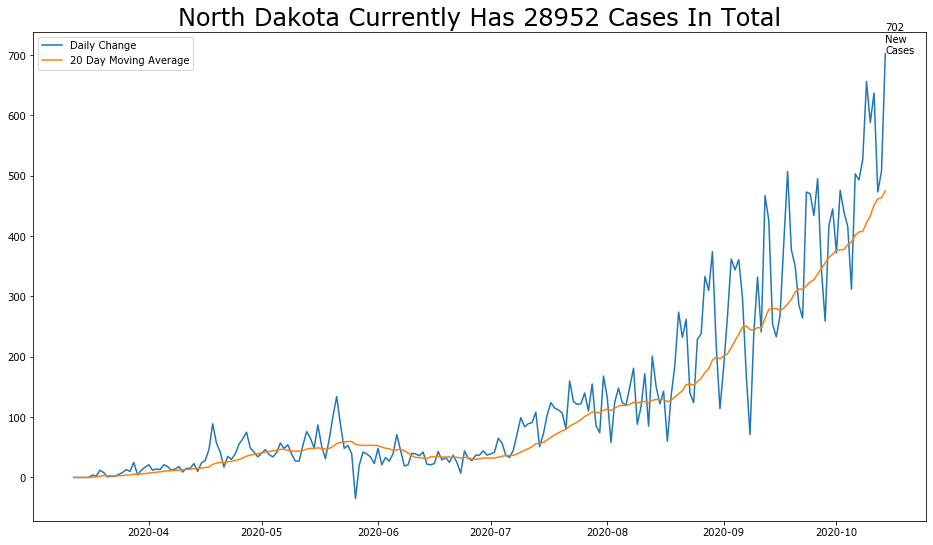

In [59]:
daily_change(north_dakota_data)

## Northern Mariana Islands (MP)

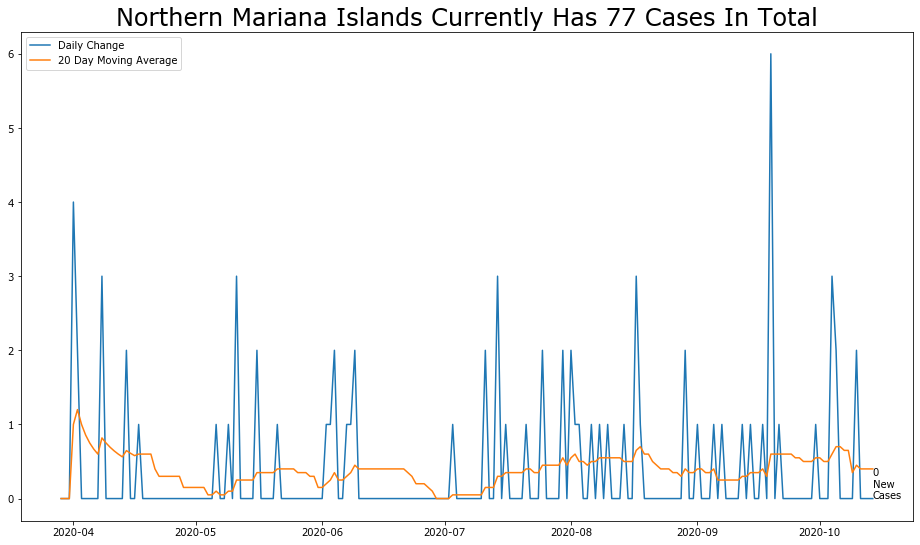

In [60]:
daily_change(north_mariana_islands_data)

## Ohio (OH)

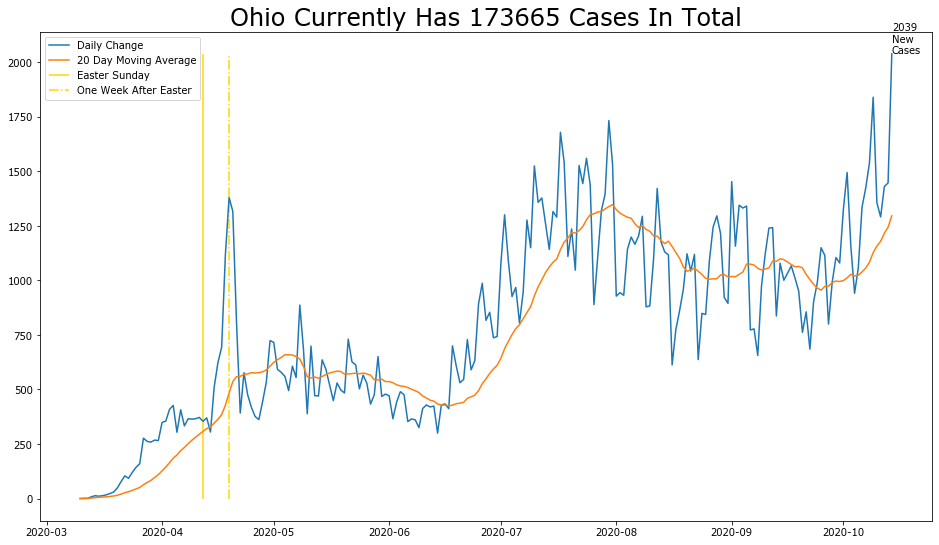

In [61]:
daily_change(ohio_data, easter='Oh Oh')

## Oklahoma (OK)

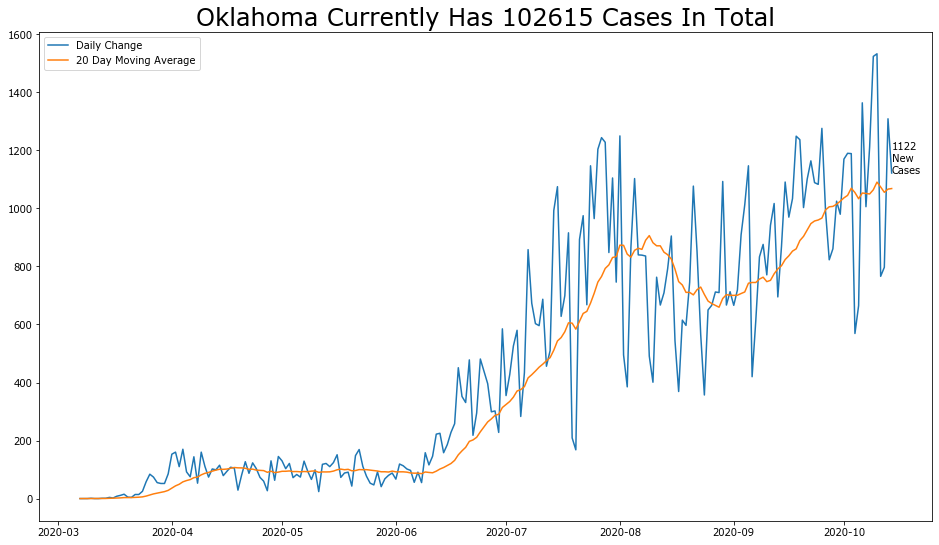

In [62]:
daily_change(oklahoma_data)

## Oregon (OR)

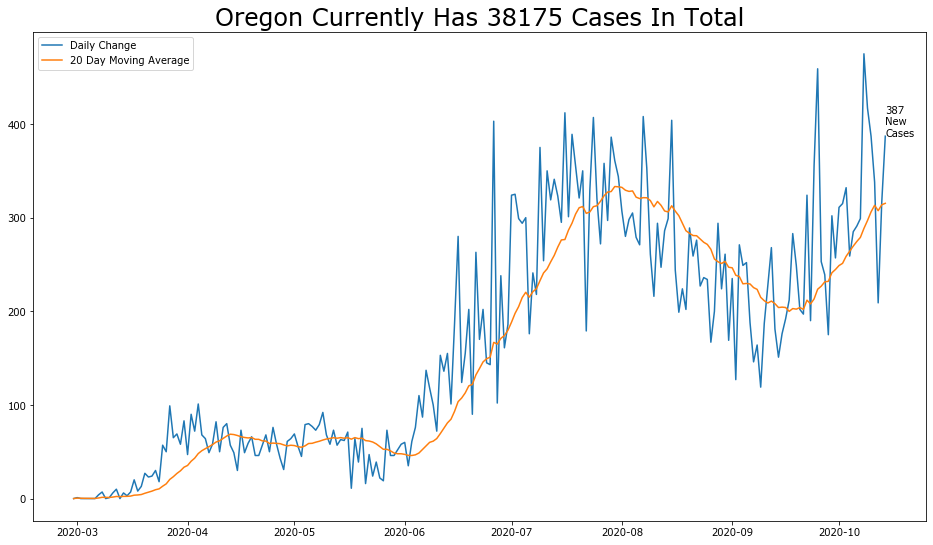

In [63]:
daily_change(oregon_data)

## Pennsylvania (PA)

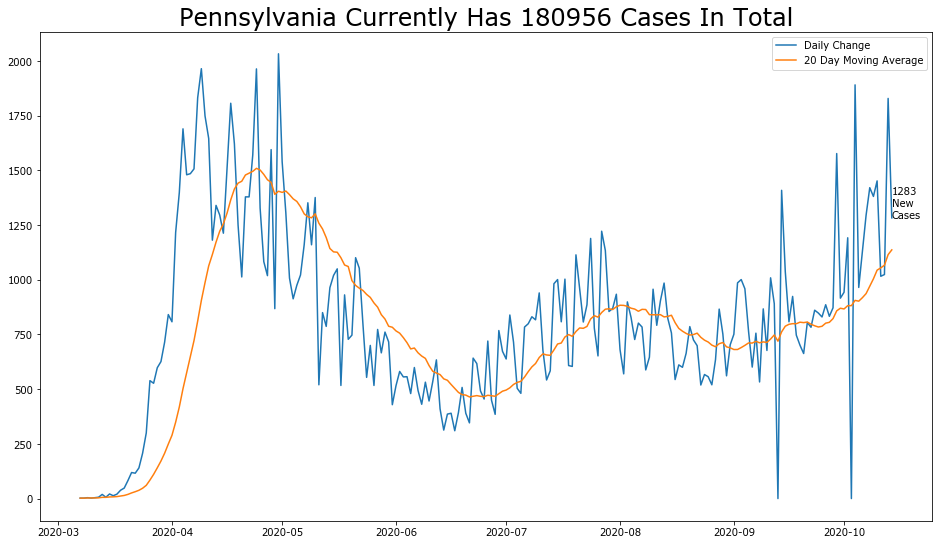

In [64]:
daily_change(pennsylvania_data)

## Puerto Rico (PR)

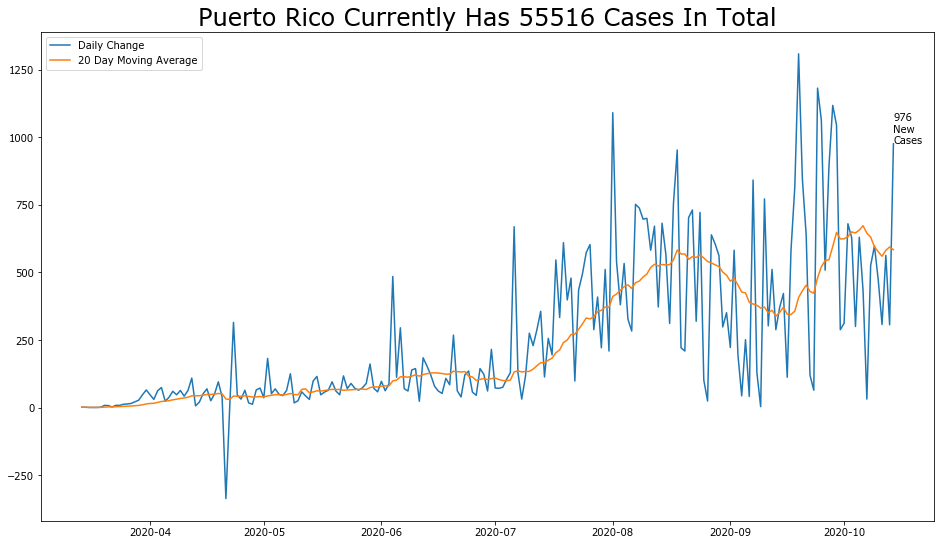

In [65]:
daily_change(puerto_rico_data)

## Rhode Island (RI)

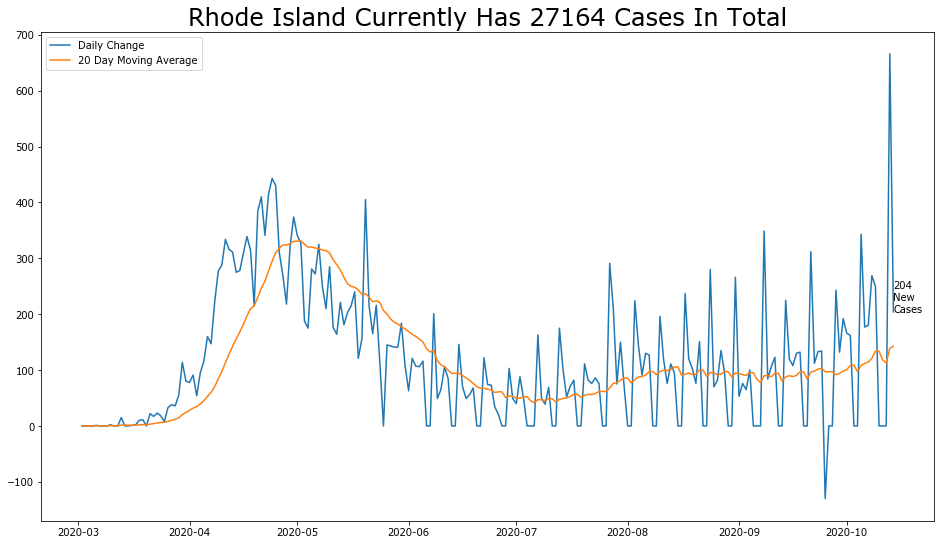

In [66]:
daily_change(rhode_island_data)

## South Carolina (SC)

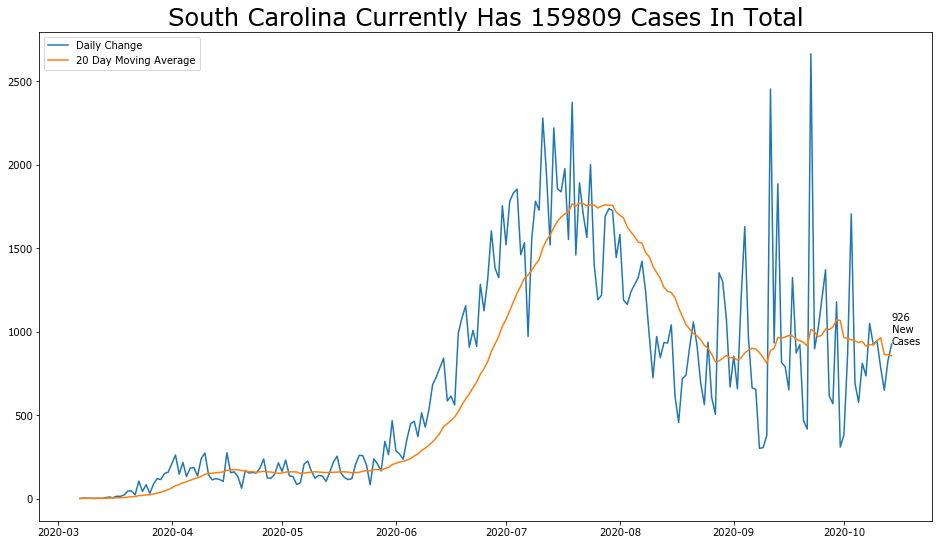

In [67]:
daily_change(south_carolina_data)

## South Dakota (SD)

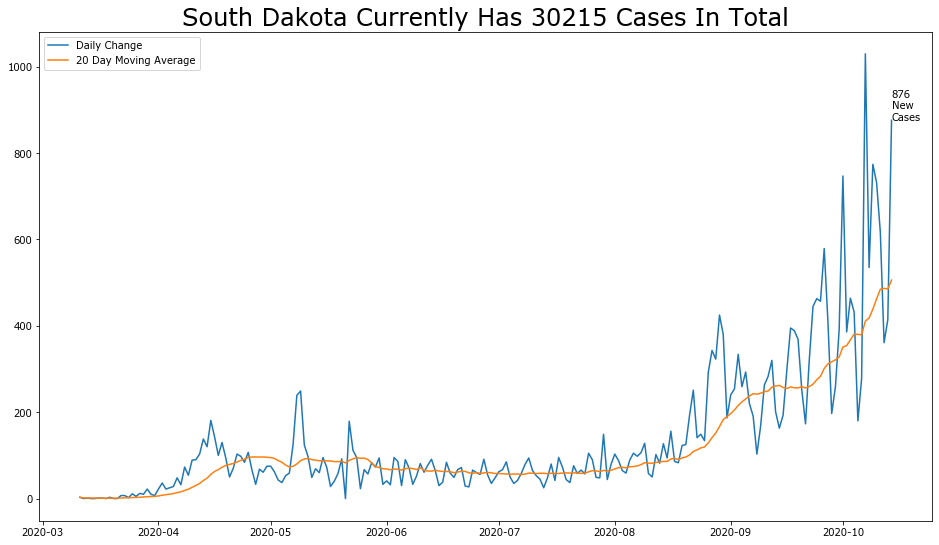

In [68]:
daily_change(south_dakota_data)

## Tennessee (TN)

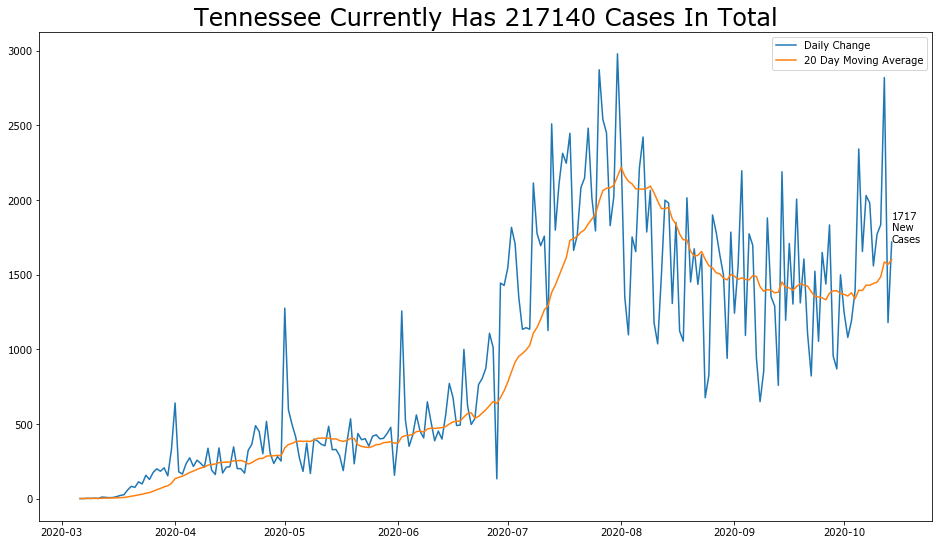

In [69]:
daily_change(tennessee_data)

## Texas (TX)

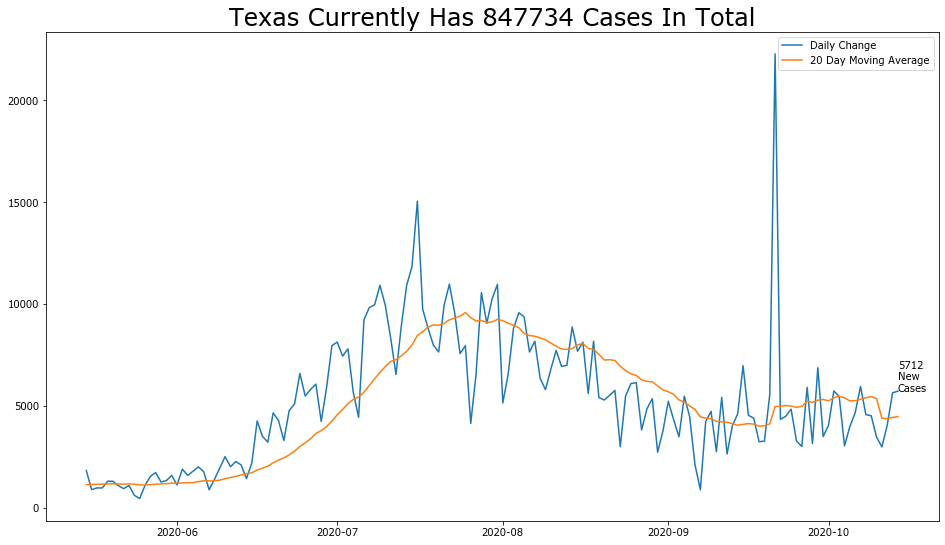

In [70]:
daily_change(texas_data[dt.date(2020, 5, 15):])

## Utah (UT)

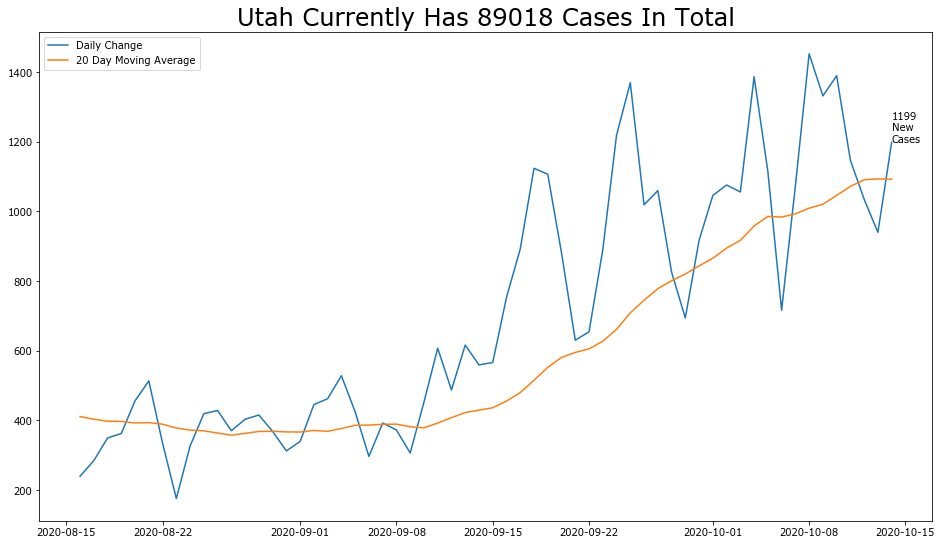

In [71]:
daily_change(utah_data[-60:])

## Vermont (VT)

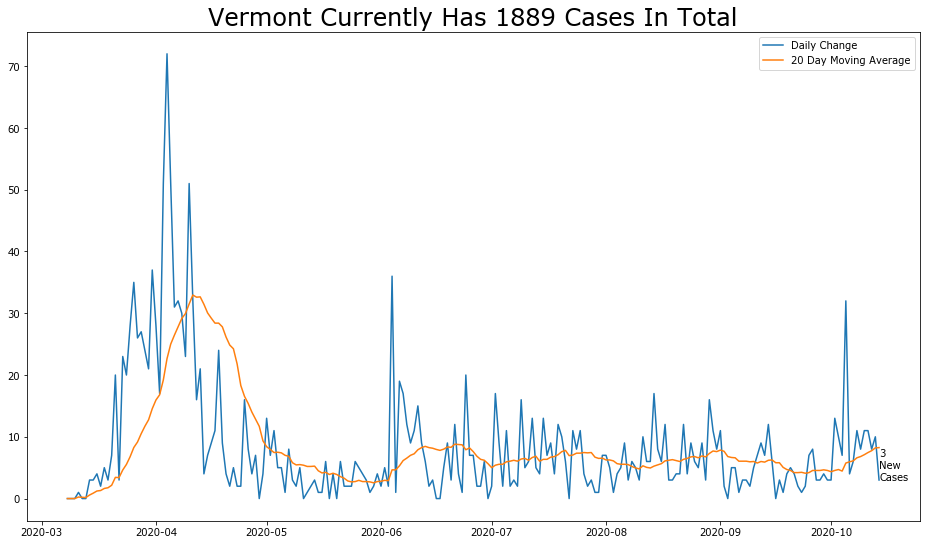

In [72]:
daily_change(vermont_data)

## Virgin Islands (VI)

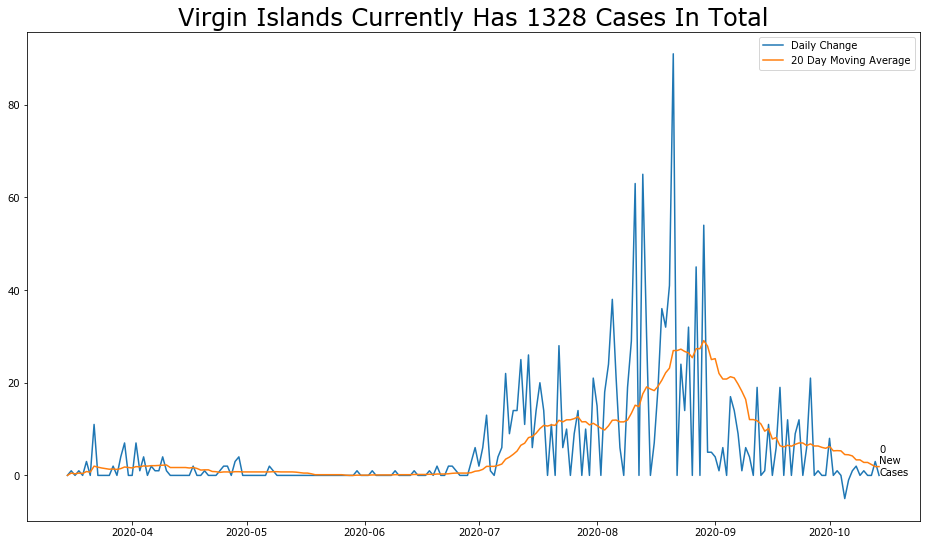

In [73]:
daily_change(virgin_islands_data)

## Virginia (VA)

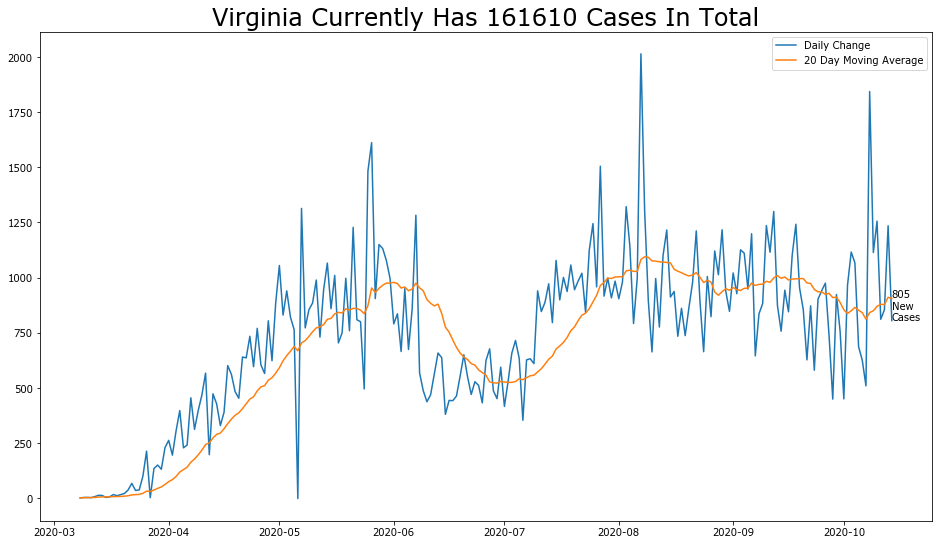

In [74]:
daily_change(virginia_data)

## Washington (WA)

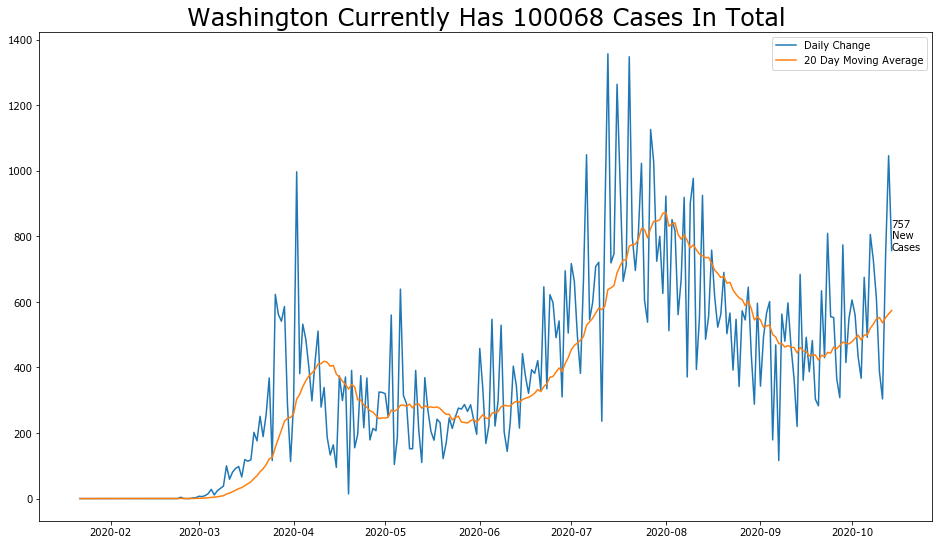

In [75]:
daily_change(washington_data)

## West Virginia (WV)

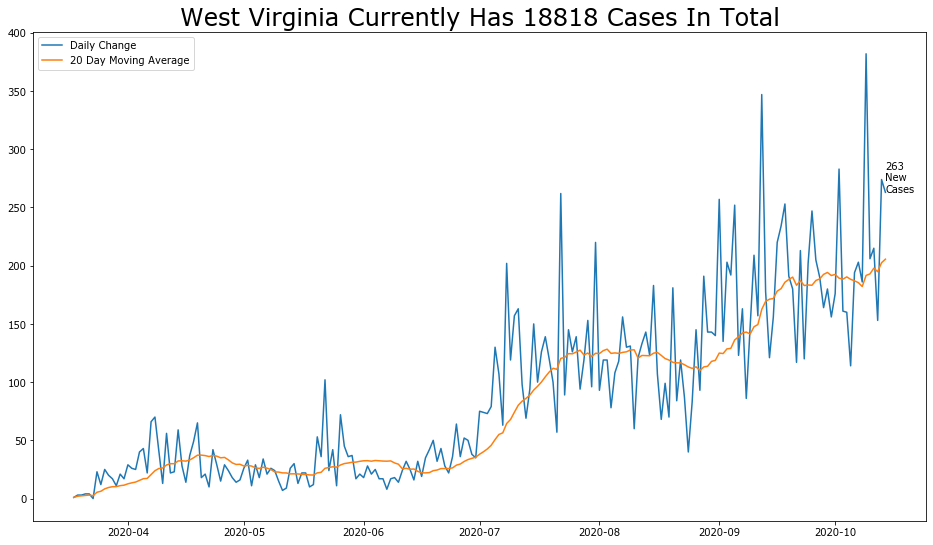

In [76]:
daily_change(west_virginia_data)

## Wisconsin (WI)

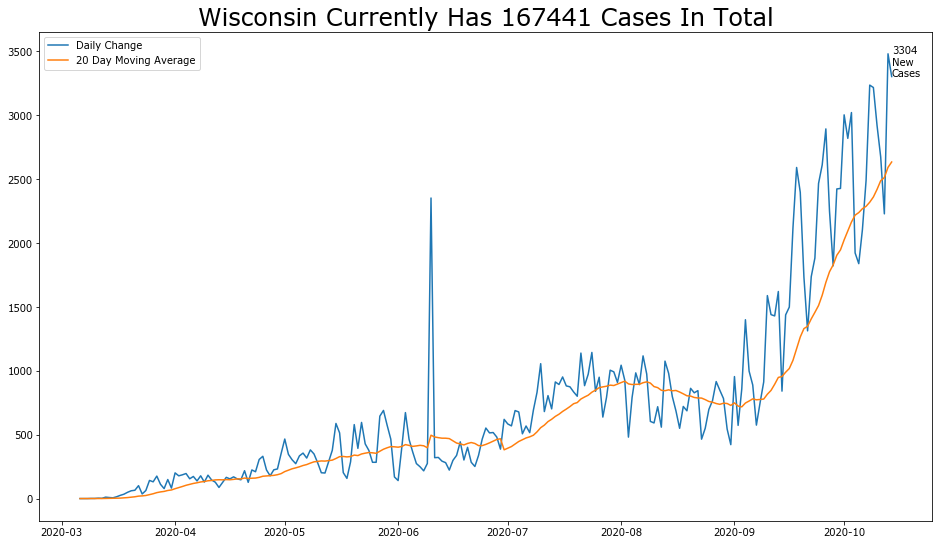

In [77]:
daily_change(wisconsin_data[30:])
# plt.vlines(x=dt.date(2020, 5, 13), ymin=wisconsin_data['change_in_cases'].min(), ymax=wisconsin_data['change_in_cases'].max(), color='red', label='Stay At Home Order Overturned')
# plt.vlines(x=dt.date(2020, 5, 20), ymin=wisconsin_data['change_in_cases'].min(), ymax=wisconsin_data['change_in_cases'].max(), linestyle='dashdot', color='red', label='One Week After Overturn')
plt.legend();

## Wyoming (WY)

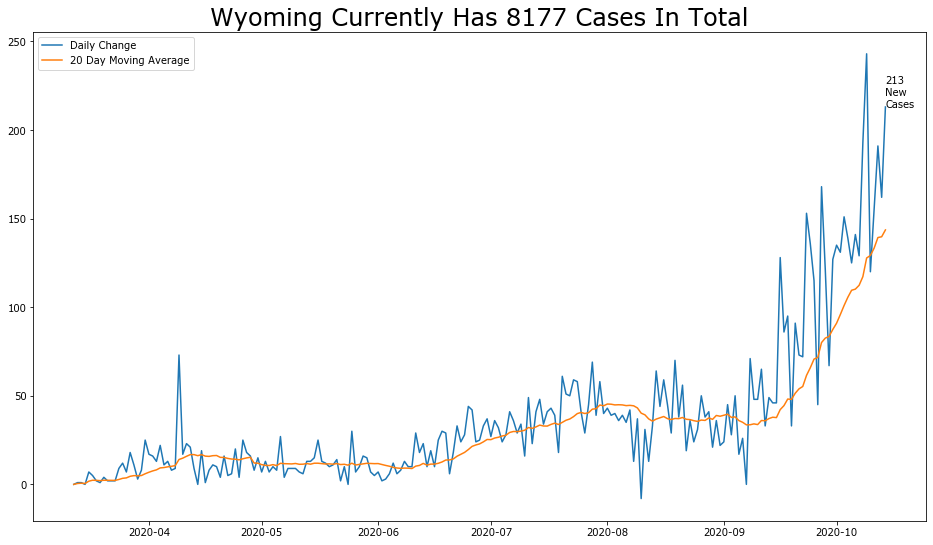

In [78]:
daily_change(wyoming_data)

## Full Nation

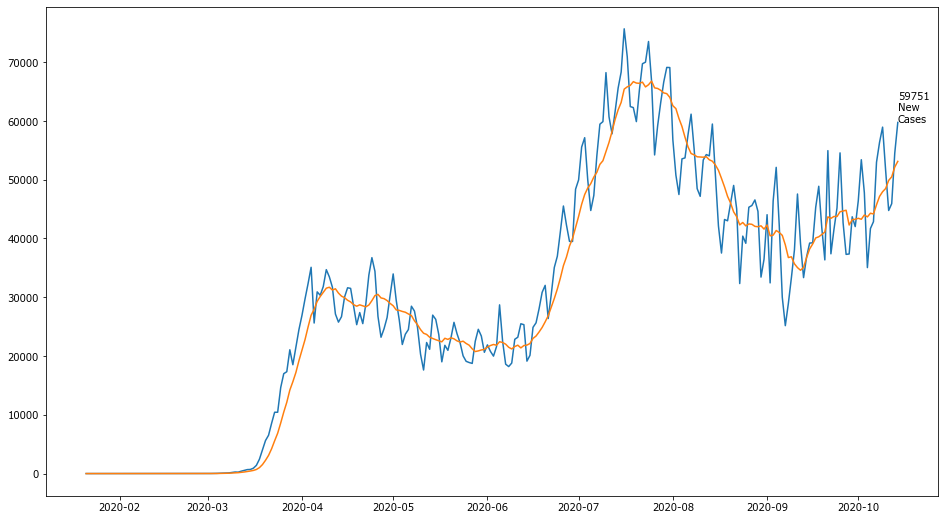

In [79]:
plt.figure(figsize=(16,9))
plt.plot(total_us_data.groupby(['date']).sum()['change_in_cases'])
plt.text(x=total_us_data.date.tail(1), y=total_us_data.groupby(['date']).sum()['change_in_cases'][-1], s=f"{int(total_us_data.groupby(['date']).sum()['change_in_cases'][-1])}\nNew\nCases");
plt.plot(total_us_data.groupby(['date']).sum()['change_in_cases'].transform(lambda x: x.rolling(7, 1).mean()))
plt.show()

## States with Most Cases

In [80]:
total_us_data.groupby(total_us_data.state).last().sort_values(by='change_in_cases', ascending=False)

date  fips   cases  deaths  percent_change  \
state                                                                       
Texas                    2020-10-14    48  847734   17276        0.006784   
Missouri                 2020-10-14    29  154213    2598        0.024698   
California               2020-10-14     6  867094   16752        0.004030   
Wisconsin                2020-10-14    55  167441    1549        0.020130   
Illinois                 2020-10-14    17  332124    9335        0.009005   
Florida                  2020-10-14    12  741624   15594        0.003903   
Ohio                     2020-10-14    39  173665    5033        0.011880   
North Carolina           2020-10-14    37  236812    3882        0.008389   
Tennessee                2020-10-14    47  217140    2801        0.007970   
Michigan                 2020-10-14    26  154409    7270        0.010252   
Georgia                  2020-10-14    13  319609    7298        0.004854   
Iowa                     2020-10-14    19  102905    1505        0.013533   
Minnesota                2020-10-14    27  115998    2233        0.011961   
Kansas                   2020-10-14    20   70665     838        0.019285   
Kentucky                 2020-10-14    21   85278    1325        0.015613   
Pennsylvania             2020-10-14    42  180956    8481        0.007141   
New York                 2020-10-14    36  482671   32916        0.002565   
Utah                     2020-10-14    49   89018     529        0.013653   
Indiana                  2020-10-14    18  141670    3836        0.008292   
Oklahoma                 2020-10-14    40  102615    1132        0.011055   
Arkansas                 2020-10-14     5   95246    1634        0.011458   
Puerto Rico              2020-10-14    72   55516     742        0.017895   
New Jersey               2020-10-14    34  217812   16191        0.004330   
South Carolina           2020-10-14    45  159809    3593        0.005828   
Nebraska                 2020-10-14    31   54467     536        0.017257   
Arizona                  2020-10-14     4  227660    5772        0.004018   
Louisiana                2020-10-14    22  176209    5695        0.005019   
Mississippi              2020-10-14    28  106817    3140        0.008269   
South Dakota             2020-10-14    46   30215     291        0.029858   
Virginia                 2020-10-14    51  161610    3381        0.005006   
Colorado                 2020-10-14     8   81205    2186        0.009837   
Alabama                  2020-10-14     1  167977    2706        0.004689   
Washington               2020-10-14    53  100068    2319        0.007623   
North Dakota             2020-10-14    38   28952     370        0.024850   
Montana                  2020-10-14    30   20287     225        0.030739   
Massachusetts            2020-10-14    25  140992    9647        0.004131   
New Mexico               2020-10-14    35   34290     921        0.017115   
Maryland                 2020-10-14    24  133413    4022        0.004321   
Nevada                   2020-10-14    32   87527    1694        0.006405   
Idaho                    2020-10-14    16   50534     520        0.010943   
Oregon                   2020-10-14    41   38175     609        0.010241   
West Virginia            2020-10-14    54   18818     391        0.014174   
Wyoming                  2020-10-14    56    8177      57        0.026745   
Rhode Island             2020-10-14    44   27164    1147        0.007567   
Connecticut              2020-10-14     9   61861    4537        0.002658   
Alaska                   2020-10-14     2   11103      60        0.013047   
Hawaii                   2020-10-14    15   13834     182        0.007135   
Guam                     2020-10-14    66    4310      62        0.017710   
Delaware                 2020-10-14    10   22465     660        0.003170   
New Hampshire            2020-10-14    33    9349     458        0.007544   
District of Columbia     20